# Lecture 3

https://www.youtube.com/watch?v=tNOu-SEacNU&list=PLDcUM9US4XdPz-KxHM4XHt7uUVGWWVSus&index=3

the lecture introduces some specific quadratic approximation functions from it's own 'rethinking' package, as well as some functions for sampling etc. We replicate the workflow here using pymc instead.


# summary (notebooklm)

The third lecture of Statistical Rethinking 2023, "Geocentric Models," uses two stories from the history of astronomy to illustrate the concepts of linear regression and Gaussian distributions.

### The Geocentric Model and Linear Regression

The geocentric model of the solar system, with the Earth at the center, was used for centuries to accurately predict planetary motion. While **the model was wrong, its ability to predict specific phenomena highlights the ability of statistical models to make accurate predictions without explaining the underlying causal mechanisms**.

**Like the geocentric model, linear regression describes associations among variables and can make excellent predictions, but is mechanistically almost always wrong.** The universe is not composed of perfectly linear relationships, and the meaning of associations in a linear regression model depends on an external causal model. However, **linear regression can be a useful tool when the distinction between the causal model and the statistical model is kept clear**.

### Gaussian Distributions and Error Models

The second astronomy story involves the discovery of the dwarf planet Ceres. Carl Friedrich Gauss, using what would now be considered Bayesian reasoning, developed a method to predict Ceres' orbit using a normal error model, also known as a Gaussian distribution.

**Gaussian distributions are common in nature because many processes involve the addition of small fluctuations**. For example, the distribution of heights in a population arises from the accumulation of small variations in growth.

**From a statistical perspective, the Gaussian distribution is the least informative distribution for estimating the mean and variance of a variable**. This means that **it can be used to estimate the mean and variance of a variable even if the variable is not empirically normally distributed**.

### Building and Understanding Linear Models

The lecture then shifts to building a linear model to describe the relationship between height and weight. The causal model assumes that **height influences weight, with other unobserved factors also contributing**.

A simple generative model is defined, where weight is proportional to height plus a Gaussian error term representing the unobserved influences. This model is then expressed in standard statistical notation, which includes:

- **Variables:** Both observed (height and weight) and unobserved (parameters and error terms).
- **Relationships:** Deterministic (e.g., the equation for weight) and distributional (e.g., the error term following a Gaussian distribution).

The concept of **prior distributions**, which represent knowledge about the parameters before seeing the data, is introduced. Priors are important for constraining the model to produce scientifically realistic predictions.

The lecture concludes by fitting the linear model to data from the Dobe !Kung people, using a quadratic approximation method to estimate the posterior distribution of the parameters. The results are visualized using pairs plots and by plotting lines sampled from the posterior distribution.

### Key Takeaways

The main points of the lecture are:

- **Statistical models can make accurate predictions without necessarily reflecting the true causal structure of a system**.
- **Gaussian distributions are common and useful in statistical modeling**.
- **Building and understanding linear models involves defining generative models, using statistical notation, choosing appropriate priors, and evaluating the posterior distribution**.
- **Prior predictive simulation is essential for understanding the implications of model assumptions**.
- **Interpreting the results of a linear regression requires considering the covariation among parameters and focusing on posterior predictions rather than individual parameter estimates**.

The lecture emphasizes the importance of understanding the limitations of statistical models and using them as tools for measurement and inference, similar to how a thermometer measures temperature.


## summary (written by me)

This lecture goes into the workflow for working with a real dataset, where we are introduced to bayesian linear regression. Two examples from astronomy are used to convey the following important points: firstly, the statistical model and causal model are different, and a statistical model can perform well given some data and be completely wrong about the causal structure of the problem (for example, linear models in nature, like linear regression). There's no problem with admitting that, as long as we are aware that the statistical and causal model can be different. Secondly, the gaussian/normal distribution is a good error distribution and comes up so much in nature because it represents the effect of small fluctuations(+ and -) in a quantity over time. Also, it is the least informative distribution for estimating the mean and variance of a distribution, and can do a good job, even if that distribution is not normally distributed. We then model a liner regression problem where the influence of height on weight is studied, with some normally distributed noise representing unknown factors effecting the relationship. The priors set are important because they reflect the model predictions when no data is introduced (the prior predictive, not the posterior predictive we learnt last week), and this output should be realistic too, for which you can plot the prior predictive distribution and check. We follow the same workflow, where we first define a generative model for the relationship with noise (whose params we can explicitly compare with the synthetic data-trained posterior distributions of the model), and then we can introduce new data, after having perfected the synthetic validation step.

A useful tip/ "law" : always do a pairplot and visualise parameter distributions, because they have a lot of variance and co-variance with others. Summary statistics are not as good. He encourages to see the statistical model as a thermometer - something that lets you measure/quantify something, but the interpretation and use depends on the specific context its used in.


In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

print(pm.__version__)

5.19.1


In [18]:
df = pd.read_csv("./data/Howell1.csv", sep=";")
df = df[df["age"] >= 18]
df

height     weight   age  male
0    151.765  47.825606  63.0     1
1    139.700  36.485807  63.0     0
2    136.525  31.864838  65.0     0
3    156.845  53.041914  41.0     1
4    145.415  41.276872  51.0     0
..       ...        ...   ...   ...
534  162.560  47.031821  27.0     0
537  142.875  34.246196  31.0     0
540  162.560  52.163080  31.0     1
541  156.210  54.062497  21.0     0
543  158.750  52.531624  68.0     1

[352 rows x 4 columns]

<Axes: xlabel='height', ylabel='weight'>

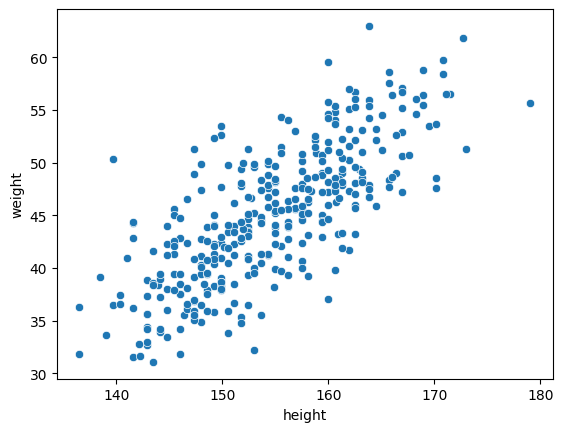

In [19]:
sns.scatterplot(df, x="height", y="weight")

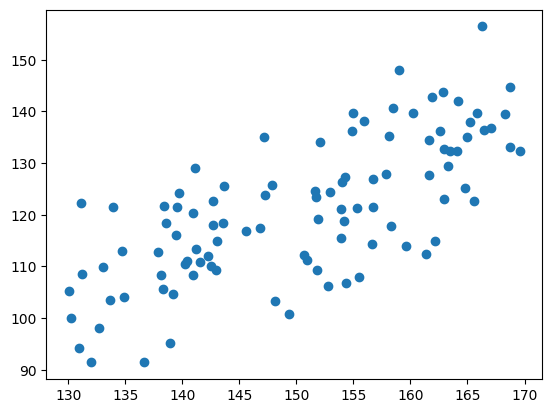

In [36]:
# some simple generative model of the data. we assume its a linear trend with normally distributed noise
def generative_model(heights, beta, sd):
    return beta * heights + np.random.normal(0, sd, heights.shape)


h = np.random.uniform(130, 170, size=100)
w = generative_model(h, 0.8, 10)
plt.scatter(h, w)

In [39]:
# lets define a statistical model which we will test the simulated data with
# our DAG is H->W. weight is what we want to estimate, using the height
# for the linear regression model here, we want the output to not be one line, but a distribution of lines
# we can assume it is normally distributed, as the normal distribution can specify the mean and variance of distributions that are not necessarily normal.
# in this bayesian linear model, for the output distribution, we want the expected value (mean) to be defined by a linear model
# and the variance (or sd) to be normally distributed with some sigma.

model = pm.Model()
with model:
    # mean,sd (var is sd^2)
    sigma = pm.Uniform("sigma", 0, 10)
    beta = pm.Uniform("beta", 0, 1)
    alpha = pm.Normal("alpha", 0, sigma=10)

    mu = alpha + beta * h
    weight = pm.Normal("weight", mu, sigma=sigma, observed=w)

In [40]:
model

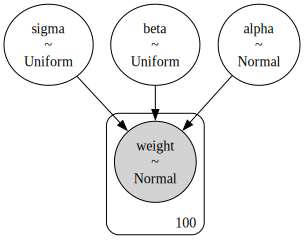

In [44]:
model.to_graphviz()

before we fit the model, see what the posterior before updating looks like, in the abscence of any data


In [86]:
with model:
    draws_prior = pm.sample_prior_predictive(100)

Sampling: [alpha, beta, sigma, weight]


In [87]:
draws_prior

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

(100, 100)


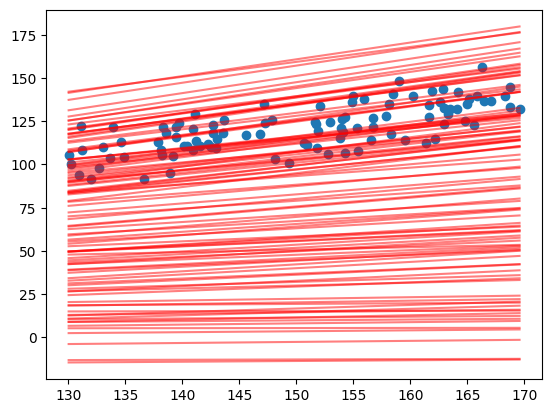

In [90]:
w_hats = draws_prior["prior_predictive"]["weight"][0]
plt.scatter(h, w)
print(w_hats.shape)
for i in range(w_hats.shape[0]):
    sorted_indices = np.argsort(h)
    alpha = draws_prior["prior"]["alpha"][0][i].values
    beta = draws_prior["prior"]["beta"][0][i].values

    # plt.plot(h[sorted_indices], w_hats[i, sorted_indices])
    plt.plot(h[sorted_indices], alpha + beta * h[sorted_indices], c="r", alpha=0.5)

In [92]:
# fit
with model:
    draws_fit = pm.sample(10_000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 9 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


A benefit of using the simulated data: we can check the true beta and sigma used in the generation of the data. alpha is a 'non physical' quantity, just used for fitting the line well.


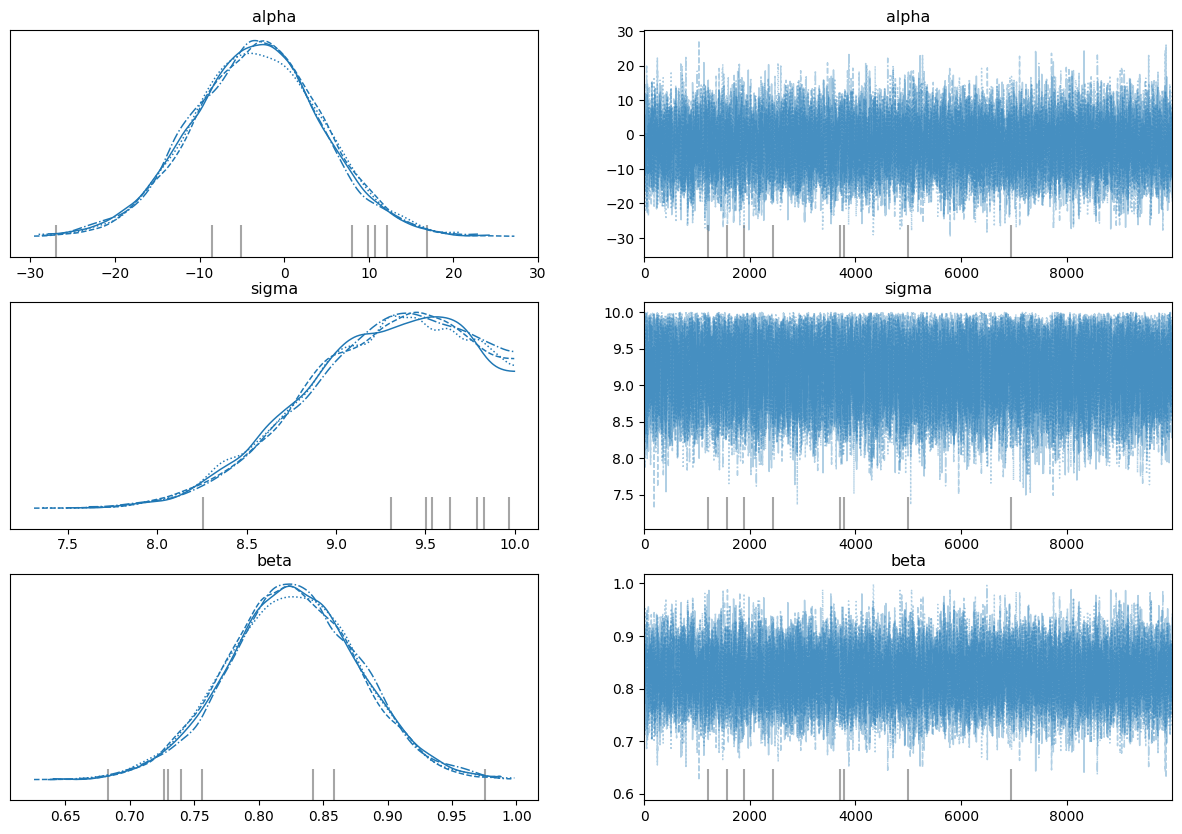

In [95]:
az.plot_trace(draws_fit, figsize=(15, 10));

In [99]:
draws_fit

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [108]:
plt.scatter(h, w)
for i in range(10):
    alpha = draws_fit["posterior"]["alpha"][0][i].values
    beta = draws_fit["posterior"]["beta"][0][i].values

    sorted_indices = np.argsort(h)
    plt.plot(h[sorted_indices], alpha + beta * h[sorted_indices], c="r", alpha=0.5)

Awesome! Now that we validate things work well on the simulation, we can try with the real dataset.


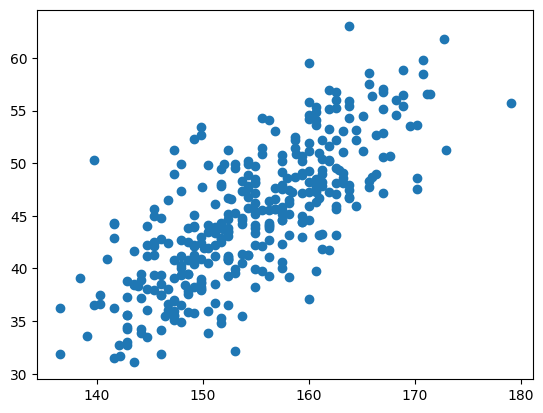

In [109]:
plt.scatter(df["height"], df["weight"])

In [110]:
model = pm.Model()
with model:
    sigma = pm.Uniform("sigma", 0, 10)
    beta = pm.Uniform("beta", 0, 1)
    alpha = pm.Normal("alpha", 0, sigma=10)
    mu = alpha + beta * df["height"]
    weight = pm.Normal("weight", mu, sigma=sigma, observed=df["weight"])

In [111]:
with model:
    draws_fit = pm.sample(10_000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 18 seconds.


In [112]:
az.plot_trace(draws_fit, figsize=(15, 10));

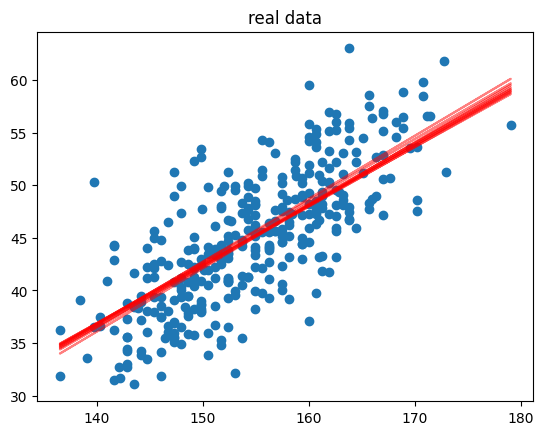

In [117]:
# posterior predictive distribution
plt.scatter(df["height"], df["weight"])
for i in range(10):
    alpha = draws_fit["posterior"]["alpha"][0][i].values
    beta = draws_fit["posterior"]["beta"][0][i].values

    plt.plot(df["height"], alpha + beta * df["height"], c="r", alpha=0.5)

plt.title("real data");

this is the std dev learnt, but the lecture used "percentile intervals"


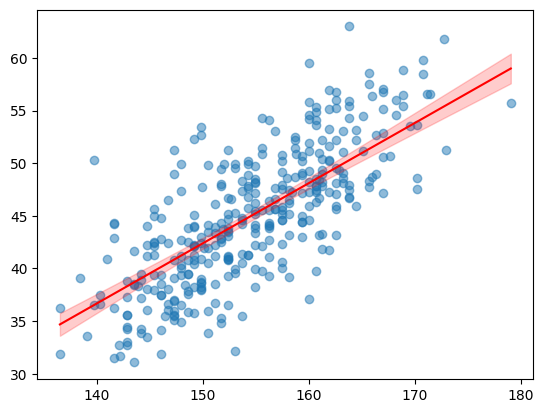

In [119]:
plt.scatter(df["height"], df["weight"], alpha=0.5)

x = np.sort(df["height"])
# Get all samples from posterior, and flatten cuz they are grouped by chain
alpha_samples = draws_fit["posterior"]["alpha"].values.flatten()
beta_samples = draws_fit["posterior"]["beta"].values.flatten()
sigma_samples = draws_fit["posterior"]["sigma"].values.flatten()

# Calculate predicted values for each posterior sample
y_pred = np.zeros((len(alpha_samples), len(x)))
for i in range(len(alpha_samples)):
    y_pred[i] = alpha_samples[i] + beta_samples[i] * x

# Calculate mean and credible intervals
y_mean = y_pred.mean(axis=0)
y_std = y_pred.std(axis=0)

# Plot mean line and credible intervals
plt.plot(x, y_mean, "r", label="Mean")
plt.fill_between(
    x,
    y_mean - 2 * y_std,  # 95% credible interval
    y_mean + 2 * y_std,
    color="r",
    alpha=0.2,
    label="95% CI",
)


# personal notes when reading chapter 4 in the book - geocentric models

- the geocentric model of the earth was wrong physically, but it usefully described the motion of the plants in the sky, using epicycles - a circle in a circle. Linear regression is like that in statistics - it is useful to describe means and variances of a measurement, but is not mechanistically sound. But it's still useful!
- linear regression refers to the use of using other measurements in an additive manner to describe another measurement.
- We use the normal distribution to describe uncertainity about some measurement.
- Any process that adds together random samples from the same distribution tends to be a normal distribution. Why? Each sample will be some deviation from the expected value, the mean. Eventually, the +&- deviations from the mean cancel out, leaving most near the expected value, and only a few outside it. This is also intuitively why despite the underlying distribution, the normal distribution can estimate the mean and variance of it.
- The range of phenomenon that tend to a gaussian extend beyond just additive - even if its small multiplicative increases, those are approximately additive, so they tend to a normal distribution. If it's _big_ multiplicative increases, then their _log_ values tend to be gaussian (because in log scale, multiplication becomes addition.) But at the heart of everything, its addition of fluctuations that gives rise to normal/gaussian distributions.
- We can say that the gaussian is a natural representation about our ignorance of some micro process.

Language for describing models

- data - observed
- parameters - unobserved
- construct variable in terms of other variables or probability distributions

The biggest challenge is then deciding which variables matter, and how do you connect them? (that is, the DAG). This language is useful because you can morenatually see how to modify things, and what assumptions are - like how linear regression, anova, ancova etc are not all that different.


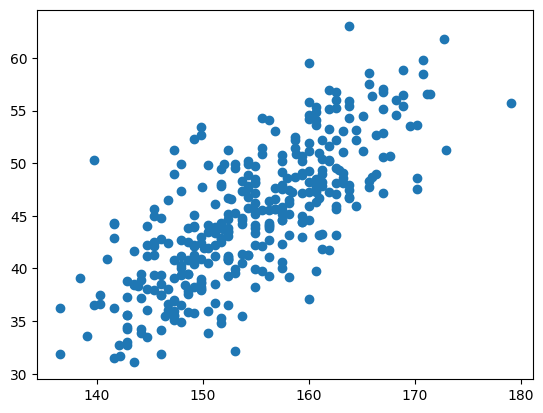

In [4]:
df = pd.read_csv("./data/Howell1.csv", sep=";")
df = df[df["age"] >= 18]

plt.scatter(df["height"], df["weight"])

In [5]:
len(df)

352

<Axes: xlabel='height', ylabel='Density'>

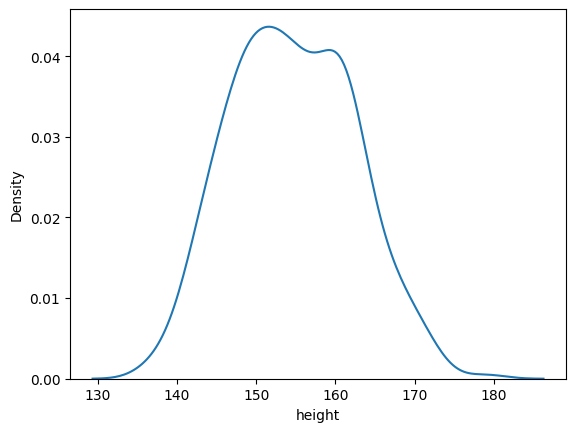

In [7]:
sns.kdeplot(df.height)

the iid assumption is not an assumption of the world, but of the model. the probability exists in the model, not in the real world.


priors are important in certain cases, which allow us to input scientific information - this is not cheating! it's a powerful way to model the world.


the priors should not be based on the data, but assumptions before you see the data. this is very important.


## modelling just the height


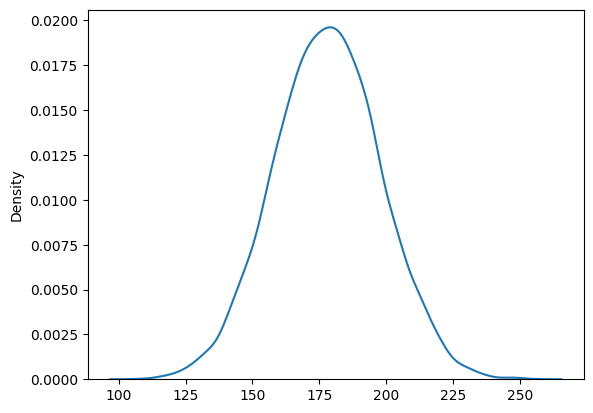

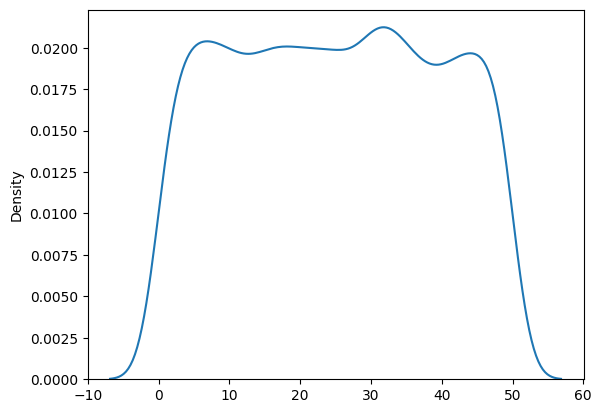

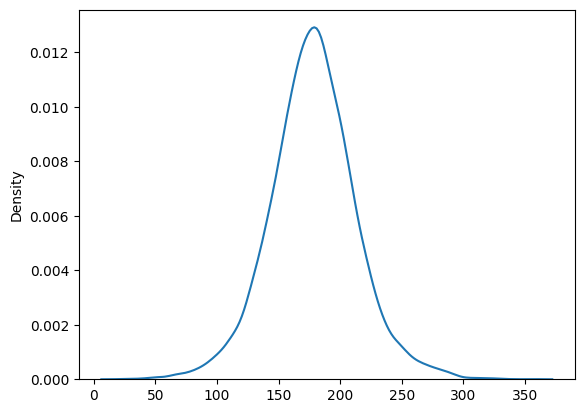

In [16]:
from scipy.stats import norm

# looking at the height dist, we can have the following model
# h~N(mu,sigma)
# mu~N(178,20)
# sigma~unif(0,50)

# let's look at the prior predictive distribution - before data is seen
n = 10000
mu = np.random.normal(178, 20, n)
sigma = np.random.uniform(0, 50, n)
height = np.random.normal(mu, sigma, n)

sns.kdeplot(mu)
plt.show()
sns.kdeplot(sigma)
plt.show()
# this is what we think about the height before observing any data
sns.kdeplot(height)
plt.show()

In [18]:
# calculations here being done in log space
# Create grid of mu and sigma values
mu_list = np.linspace(150, 160, 100)
sigma_list = np.linspace(7, 9, 100)
mu_grid, sigma_grid = np.meshgrid(mu_list, sigma_list)

# Flatten grids to get all combinations
post_mu = mu_grid.flatten()
post_sigma = sigma_grid.flatten()

# Calculate log likelihood for each combination
# Using height data from the dataframe (assuming it's called df)
ll = np.array(
    [
        np.sum(norm.logpdf(df["height"], mu, sigma))
        for mu, sigma in zip(post_mu, post_sigma)
    ]
)

# Add log prior probabilities
# Prior for mu: normal(178, 20)
# Prior for sigma: uniform(0, 50)
log_prior_mu = norm.logpdf(post_mu, 178, 20)
log_prior_sigma = np.where(
    (post_sigma >= 0) & (post_sigma <= 50), 0, -np.inf
)  # log of uniform prior

# Calculate total log probability (likelihood + priors)
log_prob = ll + log_prior_mu + log_prior_sigma

# Convert to probabilities (normalizing to avoid numerical issues)
prob = np.exp(log_prob - np.max(log_prob))


In [24]:
prob.shape

(10000,)

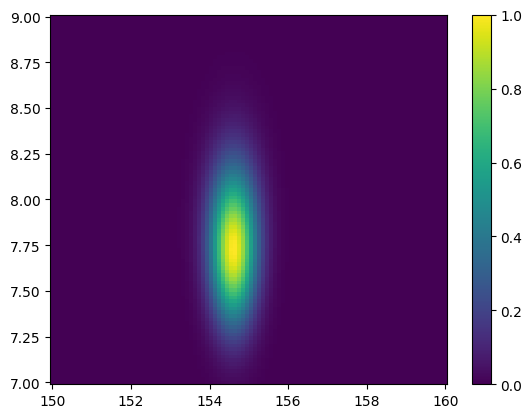

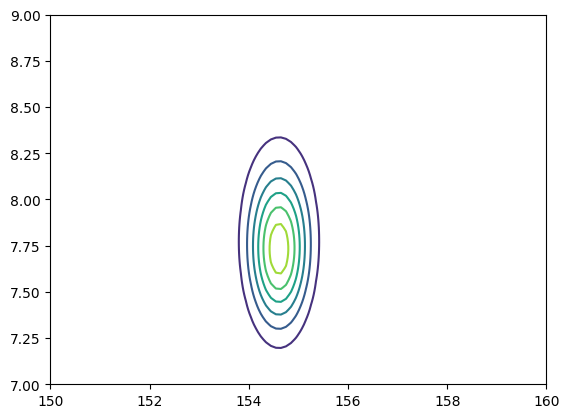

In [29]:
# this is our posterior distribution for the parameters
# Reshape the flattened arrays back to 2D grid for contour plotting
prob_2d = prob.reshape(mu_grid.shape)
plt.pcolormesh(mu_grid, sigma_grid, prob_2d, shading="auto")
plt.colorbar()
plt.show()
plt.contour(mu_grid, sigma_grid, prob_2d)

In [39]:
sum(prob)

372.86783326992963

In [38]:
sample = np.random.choice(range(len(prob)), 10000, replace=True, p=prob / sum(prob))
sample_mu = post_mu[sample]
sample_sigma = post_sigma[sample]
plt.scatter(sample_mu, sample_sigma, alpha=0.1, s=1.5)


<Axes: ylabel='Density'>

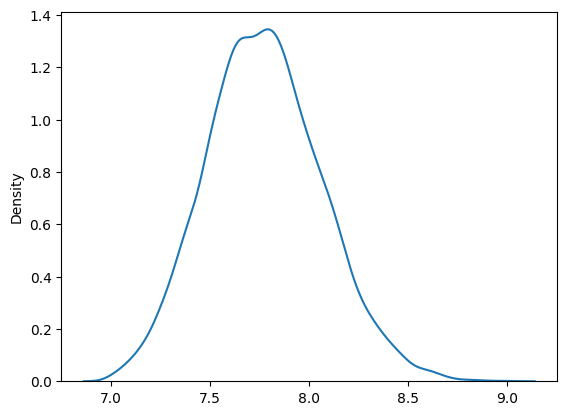

In [40]:
sns.kdeplot(sample_sigma)

<Axes: ylabel='Density'>

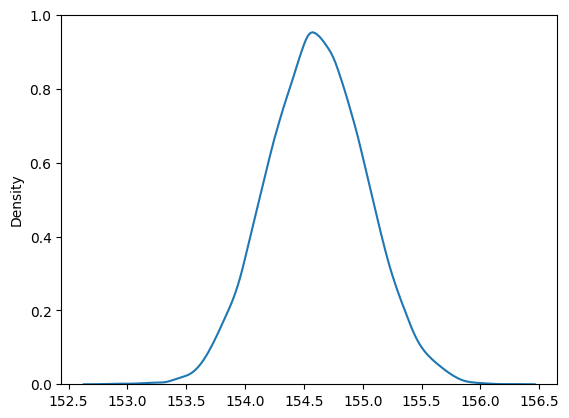

In [41]:
sns.kdeplot(sample_mu)

## mcmc!


In [43]:
with pm.Model() as height_model:
    mu = pm.Normal("mu", mu=178, sigma=20)
    sigma = pm.Uniform("sigma", 0, 50)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=df["height"])

In [44]:
height_model

    mu ~ Normal(178, 20)
 sigma ~ Uniform(0, 50)
height ~ Normal(mu, sigma)

Sampling: [height, mu, sigma]


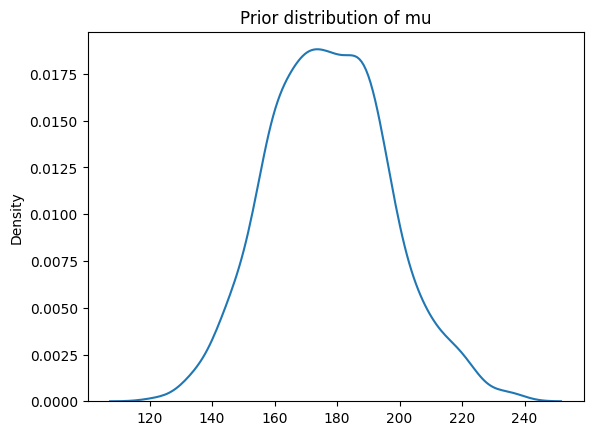

In [63]:
with height_model:
    samples_prior = pm.sample_prior_predictive(draws=1000)

sns.kdeplot(samples_prior.prior.sel(chain=0)["mu"])
plt.title("Prior distribution of mu")
plt.show()

sns.kdeplot(samples_prior.prior.sel(chain=0)["sigma"])
plt.title("Prior distribution of sigma")
plt.show()


In [64]:
with height_model:
    samples_inference = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


<Axes: ylabel='Density'>

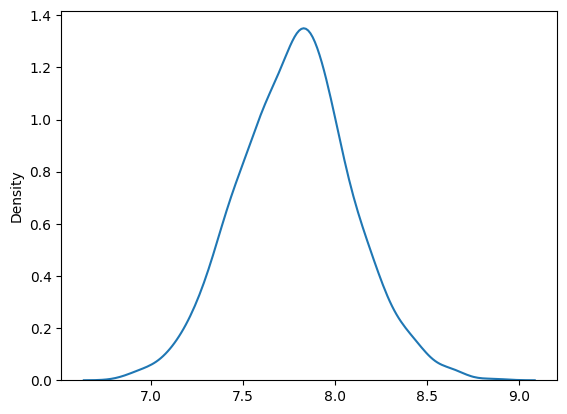

In [69]:
# sns.kdeplot(samples_prior.prior.sel(chain=0)["mu"])
sns.kdeplot(samples_inference.posterior.sel(chain=0)["mu"])
plt.show()
sns.kdeplot(samples_inference.posterior.sel(chain=0)["sigma"])
# samples_inference

In [71]:
with height_model:
    samples_posterior_pred = pm.sample_posterior_predictive(samples_inference)

Sampling: [height]


Output()

In [73]:
az.plot_ppc(samples_posterior_pred)

<Axes: xlabel='height'>

cool! so far, we have a gaussian model of height in adults.

for linear regression, we need a predictor variable, that influences the outcome. here we'll do height vs weight.


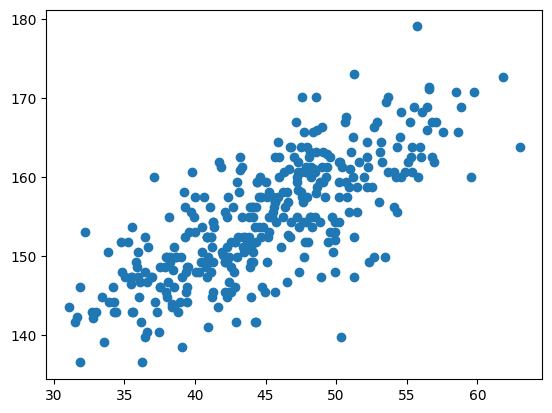

In [76]:
plt.scatter(df["weight"], df["height"])

In [77]:
df["weight"].mean()

44.99048551988636

In [78]:
with pm.Model() as reg_model:
    # alpha and beta are parameters that make mu vary in a systematic fashion
    # so that we can poke and prod mu later
    # if we want to know something for it, make it a parameter and estimate it
    alpha = pm.Normal("alpha", mu=178, sigma=20)
    beta = pm.Normal("beta", mu=0, sigma=10)
    sigma = pm.Uniform("sigma", 0, 50)
    # the diff from the mean is present here, so that its easy to set a prior for alpha, the intercept.
    # when the weight is same as the mean, alpha is the height in that case
    # so we can give it the same prior we have height in the previous modelling of the height
    mu = alpha + beta * (df["weight"] - df["weight"].mean())
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=df["height"])

priors are important, because there are cases where no amount of data will overrule the importance of the prior. Not here though, where the prior for beta doesnt matterm for example


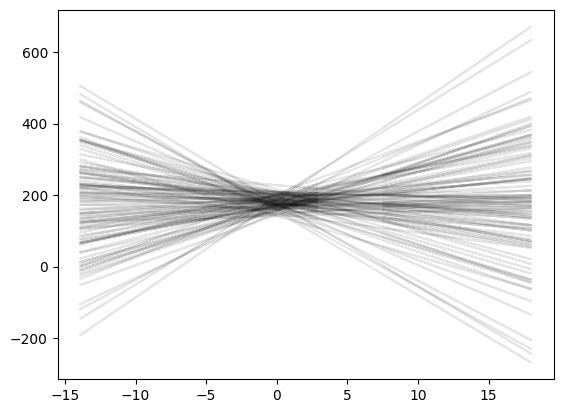

In [86]:
# simpler to get prior predictive checks without the pymc thing in this example
a = np.random.normal(178, 20, 100)
b = np.random.normal(0, 10, 100)


# we can see this prior for b isnt that great - there is negative correlations, and v high slope magnitudes
# (not relavant here tho, as data is gonna make it alright- but can tune and adjust the prior here if needed, the book makes an example of using the log normal distribution)
x = df["weight"] - df["weight"].mean()
for ai, bi in zip(a, b):
    y = ai + bi * x
    plt.plot(x, y, c="black", alpha=0.1)

again, it is bad to choose priors based on observed data - the prior should come from pre-data information, theoretical relationships, and so on.


In [79]:
reg_model

 alpha ~ Normal(178, 20)
  beta ~ Normal(0, 10)
 sigma ~ Uniform(0, 50)
height ~ Normal(f(alpha, beta), sigma)

In [80]:
with reg_model:
    samples_inference = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [81]:
with reg_model:
    samples_posterior_pred = pm.sample_posterior_predictive(samples_inference)

Sampling: [height]


Output()

In [82]:
az.plot_ppc(samples_posterior_pred)

<Axes: xlabel='height'>

when working with samples from the posterior, you'll often have to compute some quantity using it. All you have to do to take posterior uncertainity into account is to compute that quantity for all samples from the posterior, and you'll have that quantity's posterior distribution


In [90]:
pm.summary(samples_inference)

mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha  154.596  0.276  154.105  155.129      0.004    0.003    6037.0   
beta     0.905  0.042    0.828    0.985      0.001    0.000    5600.0   
sigma    5.104  0.194    4.735    5.455      0.002    0.002    6280.0   

       ess_tail  r_hat  
alpha    2986.0    1.0  
beta     3123.0    1.0  
sigma    3032.0    1.0

In [96]:
alpha_samples = samples_inference.posterior["alpha"].values.flatten()
beta_samples = samples_inference.posterior["beta"].values.flatten()
sigma_samples = samples_inference.posterior["sigma"].values.flatten()

In [ ]:
alpha_samples = samples_inference.posterior["alpha"].values.flatten()
beta_samples = samples_inference.posterior["beta"].values.flatten()
sigma_samples = samples_inference.posterior["sigma"].values.flatten()

Text(0, 0.5, 'height')

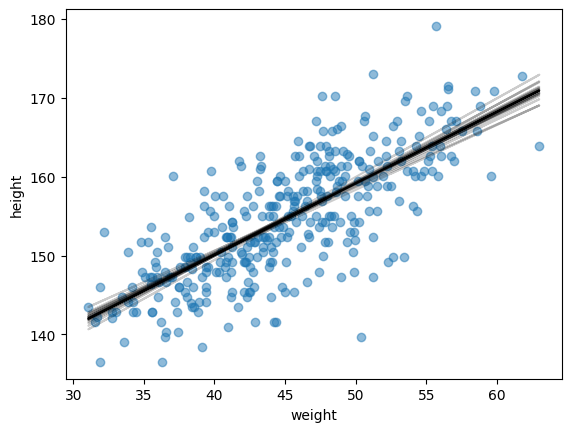

In [105]:
plt.scatter(df["weight"], df["height"], alpha=0.5)

x = df["weight"]
xbar = df["weight"].mean()
mean_line = np.mean(alpha_samples) + np.mean(beta_samples) * (x - xbar)
plt.plot(x, mean_line, c="black")

# plot some other samples for uncertainity
for i in range(20):
    a, b = alpha_samples[i], beta_samples[i]
    plt.plot(x, a + b * (x - xbar), c="black", alpha=0.2)

plt.xlabel("weight")
plt.ylabel("height")

In [119]:
# compute distribution of mu for each weight we want to consider
weights = np.arange(df["weight"].min(), df["weight"].max(), 1)

mu_dists = []
lower = []
upper = []

pi_interval = 0.89
x = 1 - pi_interval / 2

for w in weights:
    mu_dist = alpha_samples + beta_samples * (w - df["weight"].mean())
    mu_dists.append(mu_dist)
    lower.append(np.quantile(mu_dist, x))
    upper.append(np.quantile(mu_dist, 1 - x))
mu_dists = np.array(mu_dists)
lower = np.array(lower)
upper = np.array(upper)
mu_dists = mu_dists.T
mu_dists.shape

(4000, 32)

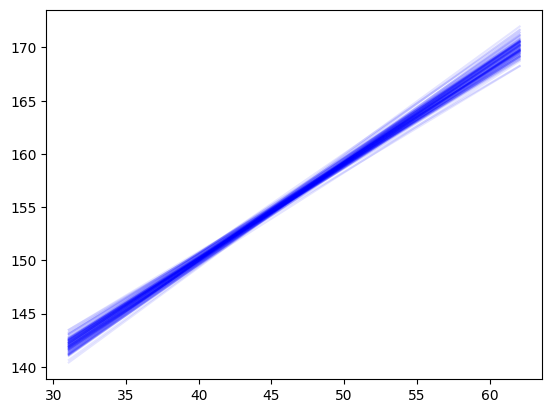

In [120]:
# Plot 100 random samples from mu_dists
for i in range(100):
    plt.plot(weights, mu_dists[i], alpha=0.1, c="blue")


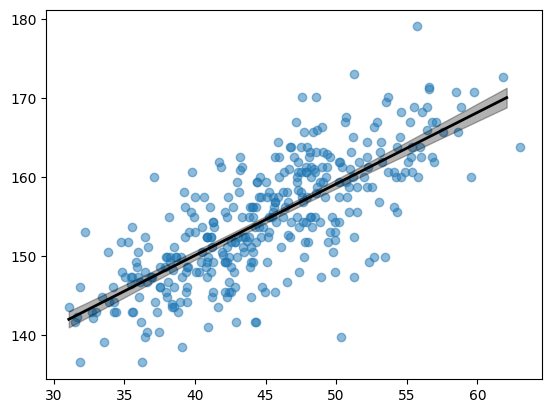

In [124]:
plt.scatter(df["weight"], df["height"], alpha=0.5)

# Compute mean and prediction intervals from mu_dists
mu_mean = np.mean(mu_dists, axis=0)
pi_interval = 0.89
x = (1 - pi_interval) / 2
mu_pi_lower = np.quantile(mu_dists, x, axis=0)
mu_pi_upper = np.quantile(mu_dists, 1 - x, axis=0)

plt.plot(weights, mu_mean, c="black", linewidth=2)
plt.fill_between(weights, mu_pi_lower, mu_pi_upper, color="black", alpha=0.3)


the compatibility intervals are quite tight, but that is conditional on the model. The book mentions that we can think of it as - given that you think the relation is linear, this is the plausible line and these are the plausible intervals.


also, these were PI's for the mean height - the intervals give an uncertainity measure for where the _mean line_ can be.

This is different from the PI for the heights, which need to incorporate sigma.


In [127]:
sigma_samples.shape

(4000,)

In [130]:
height_sim = []

for w in weights:
    mu_dist = alpha_samples + beta_samples * (w - df["weight"].mean())
    h = np.random.normal(mu_dist, sigma_samples)
    # print(h.shape)
    height_sim.append(h)
height_sim = np.array(height_sim).T

print(height_sim.shape)

(4000, 32)


In [133]:
plt.scatter(df["weight"], df["height"], alpha=0.5)
mu_mean = np.mean(mu_dists, axis=0)
pi_interval = 0.89
x = (1 - pi_interval) / 2
all_pi_lower = np.quantile(height_sim, x, axis=0)
all_pi_upper = np.quantile(height_sim, 1 - x, axis=0)

plt.plot(weights, mu_mean, c="black", linewidth=2)
plt.fill_between(weights, mu_pi_lower, mu_pi_upper, color="black", alpha=0.3)
plt.fill_between(weights, all_pi_lower, all_pi_upper, color="black", alpha=0.3)


In [135]:
samples_posterior_pred

Inference data with groups:
	> posterior_predictive
	> observed_data

<Axes: >

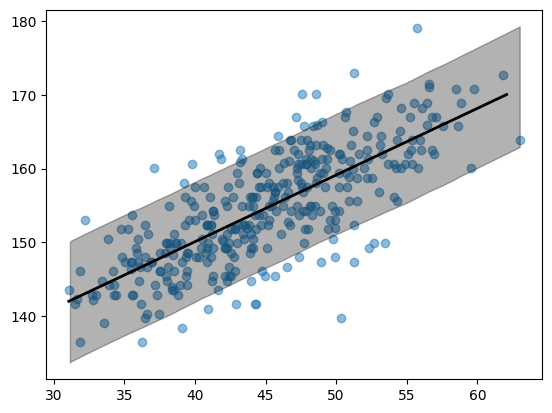

In [146]:
plt.scatter(df["weight"], df["height"], alpha=0.5)
plt.plot(weights, mu_mean, c="black", linewidth=2)
# can plot the HDI with arviz, instead of the PI like before
# seems similar to the PI as before
az.plot_hdi(
    df["weight"],
    samples_posterior_pred.posterior_predictive["height"],
    color="black",
    fill_kwargs=dict(alpha=0.3),
    hdi_prob=0.89,
)

it is possible to view the gaussian as an epistemological (way to extract knowledge) in the sense that its a tool for getting mean and variance of some variable. It's not ontological (saying the data _is_ gaussian).


## curves from lines

these are still linear models - in the sense that its additive influence of parameters that you estimate. Linear has different meanings in different contexts.

The author keeps emphasizing - if you have expert knowledge, it is often easier to do better than a linear model


let's start by looking at polynomial regression, and the whole dataset.


Text(0, 0.5, 'height')

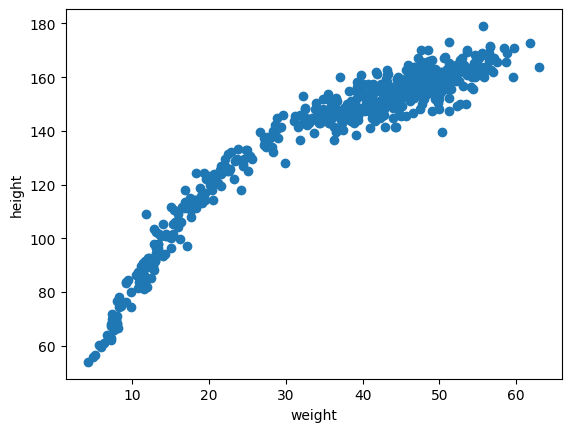

In [149]:
df = pd.read_csv("./data/Howell1.csv", sep=";")
plt.scatter(df["weight"], df["height"])
plt.xlabel("weight")
plt.ylabel("height")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta1, beta2, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [height]


Output()

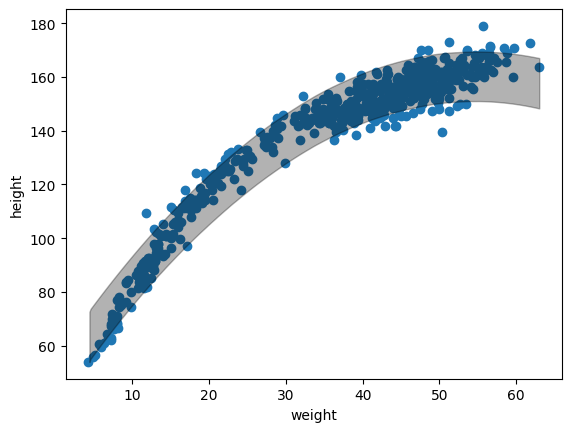

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta1, beta2, beta3, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
Sampling: [height]


Output()

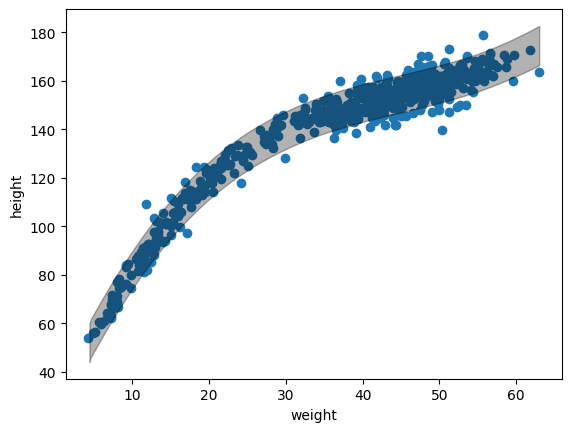

In [156]:
def fit_quadratic_model(x, y):
    with pm.Model() as poly_model:
        alpha = pm.Normal("alpha", mu=178, sigma=20)
        beta1 = pm.LogNormal("beta1", mu=0, sigma=1)
        beta2 = pm.Normal("beta2", mu=0, sigma=1)
        sigma = pm.Uniform("sigma", 0, 50)
        mu = alpha + beta1 * x + beta2 * (x**2)
        height = pm.Normal("height", mu=mu, sigma=sigma, observed=y)
        samples_inference = pm.sample()
        samples_posterior_pred = pm.sample_posterior_predictive(samples_inference)

    plt.scatter(x, y)
    az.plot_hdi(
        x,
        samples_posterior_pred.posterior_predictive["height"],
        color="black",
        fill_kwargs=dict(alpha=0.3),
        hdi_prob=0.89,
    )
    plt.xlabel("weight")
    plt.ylabel("height")


def fit_cubic_model(x, y):
    with pm.Model() as poly_model:
        alpha = pm.Normal("alpha", mu=178, sigma=20)
        beta1 = pm.LogNormal("beta1", mu=0, sigma=1)
        beta2 = pm.Normal("beta2", mu=0, sigma=1)
        beta3 = pm.Normal("beta3", mu=0, sigma=1)
        sigma = pm.Uniform("sigma", 0, 50)
        mu = alpha + beta1 * x + beta2 * (x**2) + beta3 * (x**3)
        height = pm.Normal("height", mu=mu, sigma=sigma, observed=y)
        samples_inference = pm.sample()
        samples_posterior_pred = pm.sample_posterior_predictive(samples_inference)

    plt.scatter(x, y)
    az.plot_hdi(
        x,
        samples_posterior_pred.posterior_predictive["height"],
        color="black",
        fill_kwargs=dict(alpha=0.3),
        hdi_prob=0.89,
    )
    plt.xlabel("weight")
    plt.ylabel("height")


fit_quadratic_model(df["weight"], df["height"])
plt.show()
fit_cubic_model(df["weight"], df["height"])
plt.show()

In [2]:
blossom_data = pd.read_csv("./data/cherry_blossoms.csv", sep=";")[["doy", "year"]]
blossom_data = blossom_data.dropna()

In [3]:
blossom_data.describe()

doy         year
count  827.000000   827.000000
mean   104.540508  1548.841596
std      6.407036   304.149774
min     86.000000   812.000000
25%    100.000000  1325.000000
50%    105.000000  1583.000000
75%    109.000000  1803.500000
max    124.000000  2015.000000

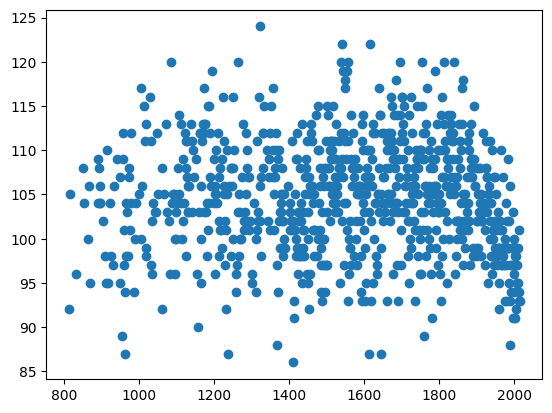

In [4]:
plt.scatter(blossom_data["year"], blossom_data["doy"])

polynomical regression doesnt do well - the ends have high uncertainty, and the number of wiggles you want has to be proportional to the polynomial order.

Also, all points effect the curve - so a point at the end can effect a point at the start - we want local control, which is what splines have to offer.


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta1, beta2, beta3, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [height]


Output()

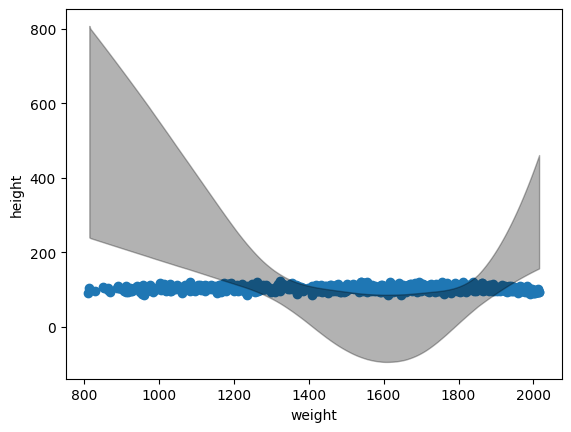

In [166]:
fit_cubic_model(blossom_data["year"], blossom_data["doy"])

let's look at splines in more detail! A spline is made up of smaller component functions (basis functions in B-splines), that are made to be continuous together.

Like polynomical regression, we have a linear combination of variables - but these are not input variables, but basis functions, combinations of which form the spline curve. The author calls these "synthetic" predictor variables. Esentially, since the basis functions have local influence (zero in areas they dont act on), their parameters also have only local influence.


knots are pivots for basis functions - more knots means there will be a more flexible spline. This does not mean that more basis functions will contribute at a single point - that is determined by the spline degree. Rather, it will mean there are more basis functions, each with a smaller local influence.


Text(0.5, 1.0, 'knot locations')

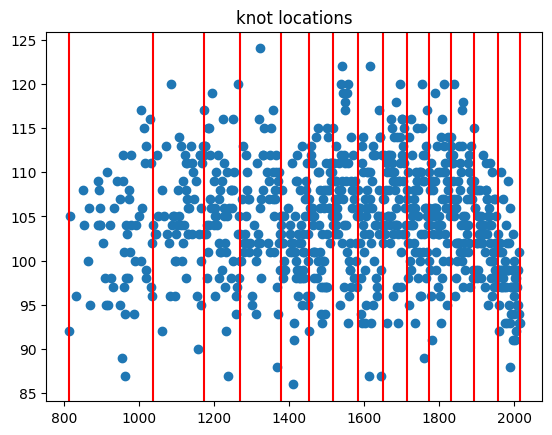

In [170]:
num_knots = 15

# knots will divide the x axis into regions, so take quantiles from it
# using quantiles will give you more knots where there is more data
# bascially, allow spline to be more blendy in more data regions
knot_list = np.quantile(blossom_data["year"], q=np.linspace(0, 1, num=num_knots))
plt.scatter(blossom_data["year"], blossom_data["doy"])
for v in knot_list:
    plt.axvline(v, c="r")

plt.title("knot locations")

for a degree-n spline, n+1 basis functions will contribute at one point


In [16]:
len(blossom_data)

827

In [27]:
from scipy.interpolate import splev


def get_spline_basis(x, knots: np.ndarray, degree: int, intercept: bool):
    """Logic from patsy : https://github.com/pydata/patsy/blob/master/patsy/splines.py"""
    order = degree + 1
    lower_bound = np.min(x)
    upper_bound = np.max(x)
    # we want duplicate values for the boundary knots usually.
    all_knots = np.concatenate(([lower_bound, upper_bound] * order, knots))
    all_knots.sort()

    n_bases = len(all_knots) - order
    basis = np.empty((x.shape[0], n_bases), dtype=float)
    # splev returns a linear combination of basis functions
    # we make the linear combination values one-hot to get
    # individual basis functions
    for i in range(n_bases):
        coefs = np.zeros(n_bases)
        coefs[i] = 1
        basis[:, i] = splev(x, (all_knots, coefs, degree))

    if not intercept:
        # ignore first column
        basis = basis[:, 1:]
    return basis


In [129]:
B = get_spline_basis(
    blossom_data["year"],
    knots=knot_list[1:-1],
    degree=3,
    intercept=True,
)
B.shape

(827, 17)

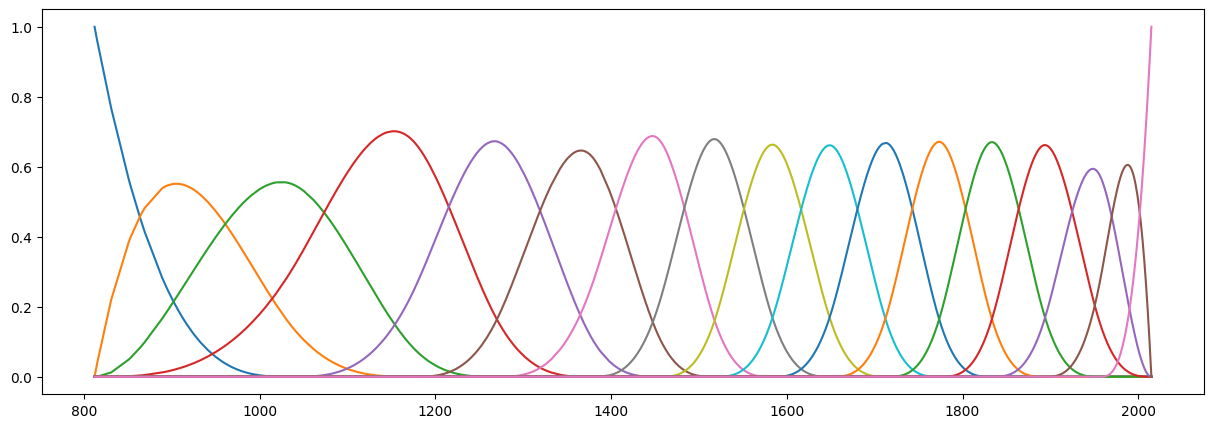

In [42]:
plt.figure(figsize=(15, 5))

for i in range(B.shape[-1]):
    plt.plot(blossom_data["year"], B[:, i])

In [58]:
with pm.Model() as spline_model:
    alpha = pm.Normal("alpha", mu=100, sigma=10)

    betas = []
    for i in range(B.shape[-1]):
        betas.append(pm.Normal(f"beta{i+1}", mu=0, sigma=10))

    mu = alpha
    for i, b in enumerate(betas):
        mu += b * B[:, i]

    # eponential is a good prior for scale, since it must be positive
    sigma = pm.Exponential("sigma", 1)

    doy = pm.Normal("doy", mu=mu, sigma=sigma, observed=blossom_data["doy"])
    prior = pm.sample_prior_predictive()
    posterior = pm.sample()
    posterior_pred = pm.sample_posterior_predictive(samples_inference)


Sampling: [alpha, beta1, beta10, beta11, beta12, beta13, beta14, beta15, beta16, beta17, beta2, beta3, beta4, beta5, beta6, beta7, beta8, beta9, doy, sigma]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta1, beta2, beta3, beta4, beta5, beta6, beta7, beta8, beta9, beta10, beta11, beta12, beta13, beta14, beta15, beta16, beta17, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
Sampling: [doy]


Output()

In [85]:
posterior

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

(19, 1000)


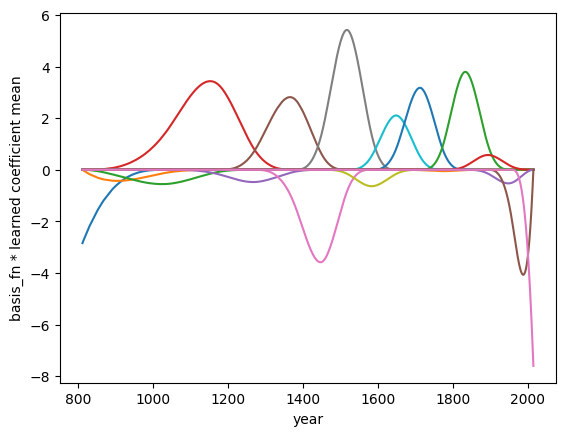

In [136]:
posterior_param_samples = np.array(
    list(posterior.posterior.sel(chain=0).data_vars.values())
)
print(posterior_param_samples.shape)

mu_data = []
for i in range(posterior_param_samples.shape[0]):
    # first is alpha and  the last is sigma, so ignore it
    if 0 < i < (len(posterior_param_samples) - 1):
        plt.plot(
            blossom_data["year"], posterior_param_samples[i, :].mean() * B[:, i - 1]
        )
plt.xlabel("year")
plt.ylabel("basis_fn * learned coefficient mean");

In [141]:
alpha = posterior_param_samples[0, :]
betas = posterior_param_samples[1:-1, :]
print(betas.shape)
# now , each row has computed basis function values (which is in array B)
# for each row, we'll get a dist of mu
# we can plot mu samples or PI's of them

mus = []

for i in range(len(blossom_data["year"])):
    model_inp = B[i, :]
    mu_dist = alpha.copy()  # important to create a deep copy here
    for j in range(betas.shape[0]):
        mu_dist += betas[j, :] * model_inp[j]
    if i == 0:
        print("shape of a single mu dist is ", mu_dist.shape)
    mus.append(mu_dist)

mus = np.array(mus)
print(mus.shape)

(17, 1000)
shape of a single mu dist is  (1000,)
(827, 1000)


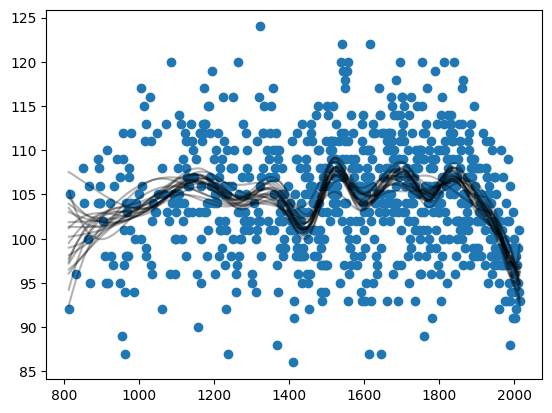

In [169]:
# plot some sample means
plt.scatter(blossom_data["year"], blossom_data["doy"])
# plt.plot(blossom_data["year"], mus.mean(axis=1))
for i in np.random.randint(0, mus.shape[-1], size=20):
    plt.plot(blossom_data["year"], mus[:, i], c="black", alpha=0.3)

Text(0.5, 1.0, 'the 97% posterior interval for mu (not of the whole data)')

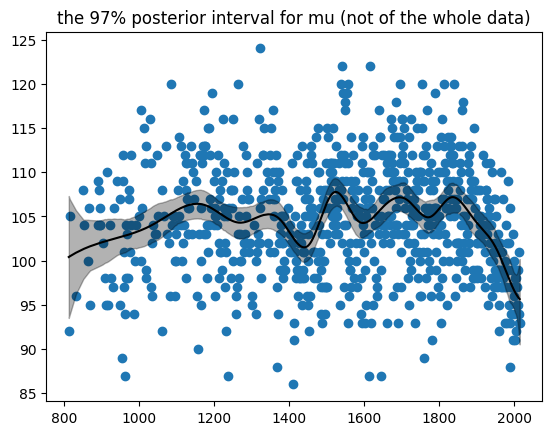

In [154]:
plt.scatter(blossom_data["year"], blossom_data["doy"])

plt.plot(blossom_data["year"], mus.mean(axis=1), c="black")

pred_interval = 0.97
x = (1 - pred_interval) / 2
plt.fill_between(
    blossom_data["year"],
    np.quantile(mus, x, axis=1),
    np.quantile(mus, pred_interval + x, axis=1),
    alpha=0.3,
    color="black",
)

plt.title("the 97% posterior interval for mu (not of the whole data)")

Text(0, 0.5, 'doy')

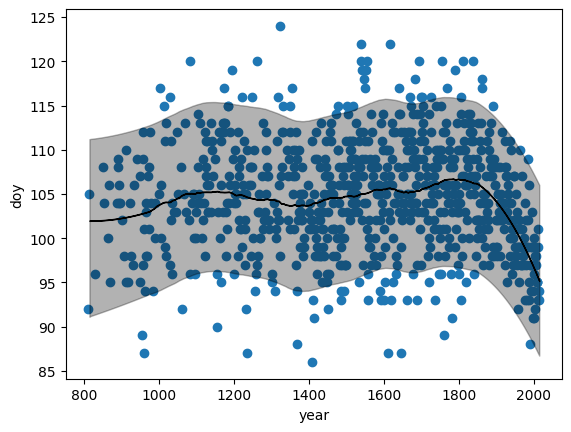

In [59]:
plt.scatter(blossom_data["year"], blossom_data["doy"])
az.plot_hdi(
    blossom_data["year"],
    posterior_pred.posterior_predictive["doy"],
    color="black",
    fill_kwargs=dict(alpha=0.3),
    hdi_prob=0.89,
)
# hack: 0.5% hdi as proxy for mean
az.plot_hdi(
    blossom_data["year"],
    posterior_pred.posterior_predictive["doy"],
    color="black",
    fill_kwargs=dict(alpha=1),
    hdi_prob=0.005,
)
plt.xlabel("year")
plt.ylabel("doy")

the author says splies are just the beginning - generalised additive models (GAMs) focus on using functions of predictor variables to predict outcome (along the lines of the basis functions being a function of our predictor variable)


## chapter 4 homework


1. 4e1 : yi~norm is the likelihood, since it is the probability of out|params. the params|out is the posterior.
2. 4e2 : there will be two parameters in the posterior distribution. the final yi is not a parameter, it is the likelihood using which the posterior is computed
3. 4e3 : P(mu,sigma | y) = P(y|mu,sigma)P(mu,sigma) / P(y)
4. 4e4: the mu_i line is the linear model.
5. 4e5: 3 parameters - alpha, beta and sigma.


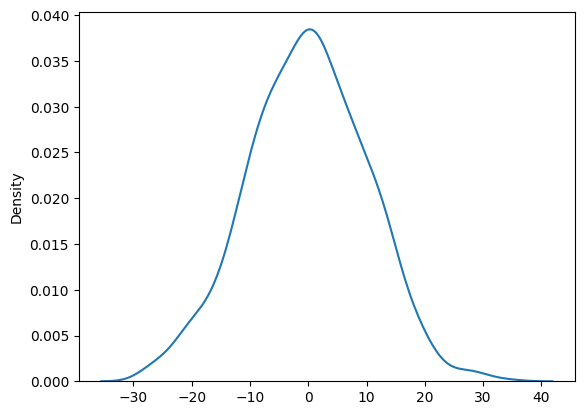

In [186]:
# 4m1
n = 1000

samples = []
for i in range(n):
    sigma = np.random.exponential(1)
    mu = np.random.normal(0, 10)
    y = np.random.normal(mu, sigma)
    samples.append(y)

sns.kdeplot(samples);

In [187]:
# 4m2 - we pymc-ing it, not quappin
with pm.Model() as hw_4m2:
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Normal("mu", 0, 10)
    y = pm.Normal("y", mu, sigma)
hw_4m2

sigma ~ Exponential(f())
   mu ~ Normal(0, 10)
    y ~ Normal(mu, sigma)

4m3

```
sigma ~ exp(1)
a ~ norm(0,10)
b ~ norm(0,1)
mu = a + b*x
y ~ norm(mu,sigma)
```

> mathematical notiation uses subscript "i" for x and y!


4m4

```
height ~ norm(mu, sigma)
mu = alpha + beta*(year - year.mean)

alpha ~ norm(170,40)
beta ~ norm(0,5)

sigma ~ exp(1)

```

4m5

I would enforce stricter priors on beta - maybe lognormal, to ensure only positive slopes.

4m6 : sigma ~ norm(0,8)

> the solution says uniform prior for this one tho


## 4m7


In [ ]:
# m4.7

df = pd.read_csv("./data/Howell1.csv", sep=";")
df = df[df["age"] >= 18]

In [189]:
with pm.Model() as model_4m7_1:
    alpha = pm.Normal("alpha", mu=178, sigma=20)
    beta = pm.Normal("beta", mu=0, sigma=10)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = alpha + beta * (df["weight"] - df["weight"].mean())
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=df["height"])
    posterior_1 = pm.sample()
    posterior_pred_1 = pm.sample_posterior_predictive(posterior_1)

with pm.Model() as model_4m7_2:
    alpha = pm.Normal("alpha", mu=178, sigma=20)
    beta = pm.Normal("beta", mu=0, sigma=10)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = alpha + beta * df["weight"]
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=df["height"])
    posterior_2 = pm.sample()
    posterior_pred_2 = pm.sample_posterior_predictive(posterior_2)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [height]


Output()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [height]


Output()

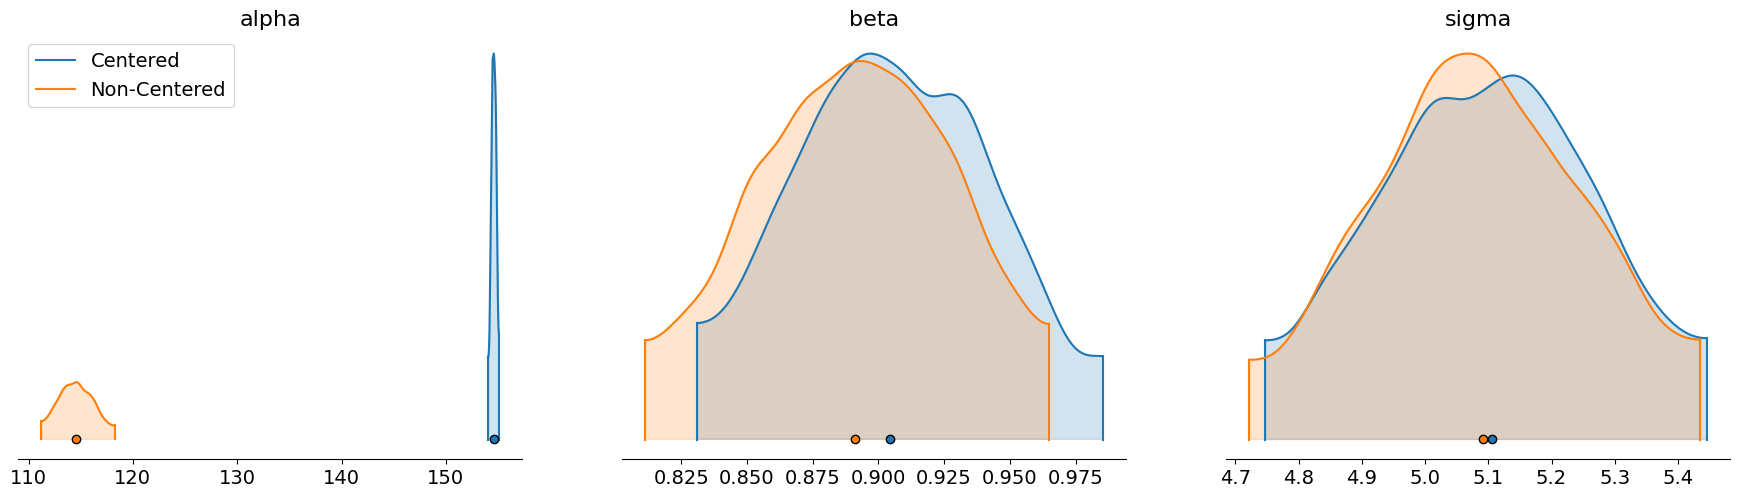

In [194]:
axes = az.plot_density(
    [posterior_1, posterior_2],
    data_labels=["Centered", "Non-Centered"],
    shade=0.2,
)


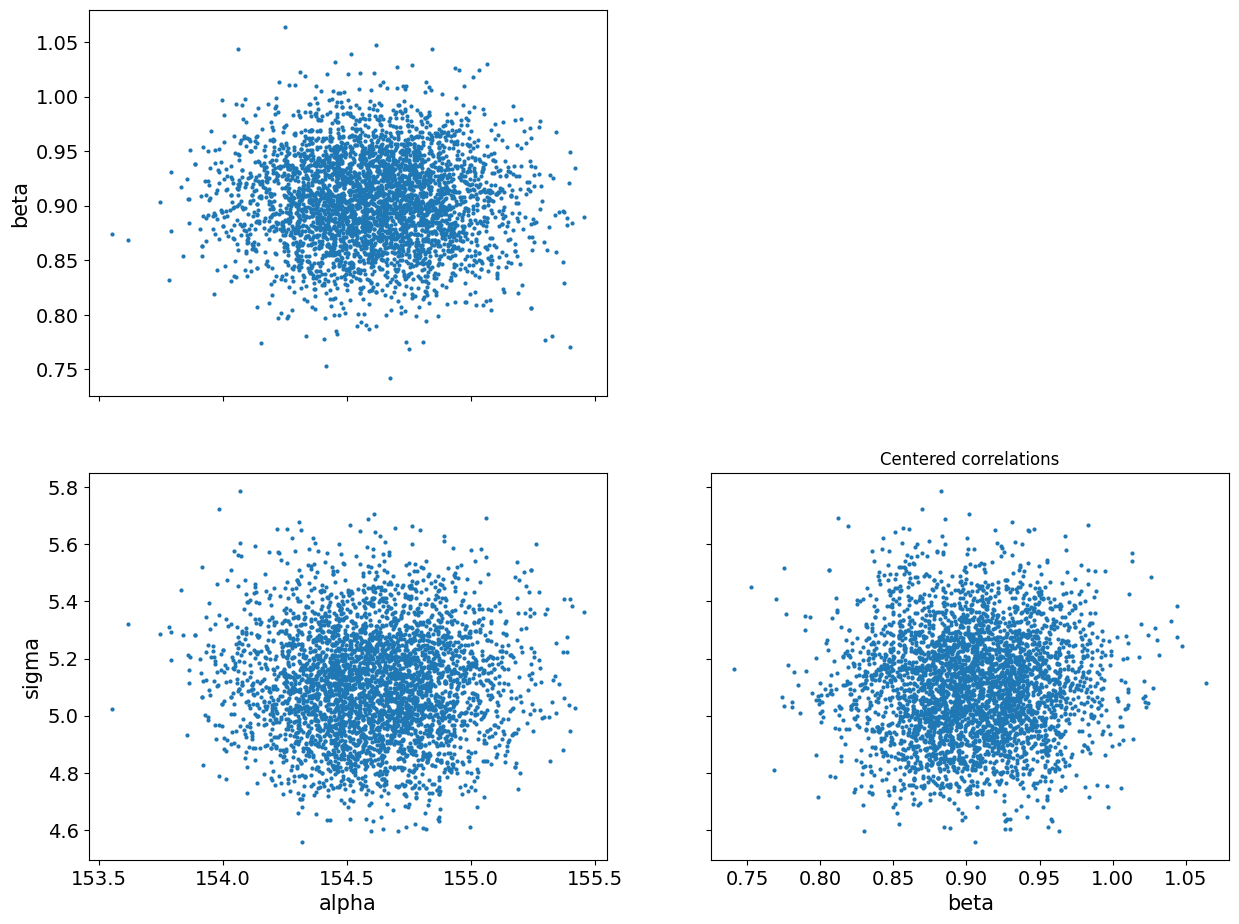

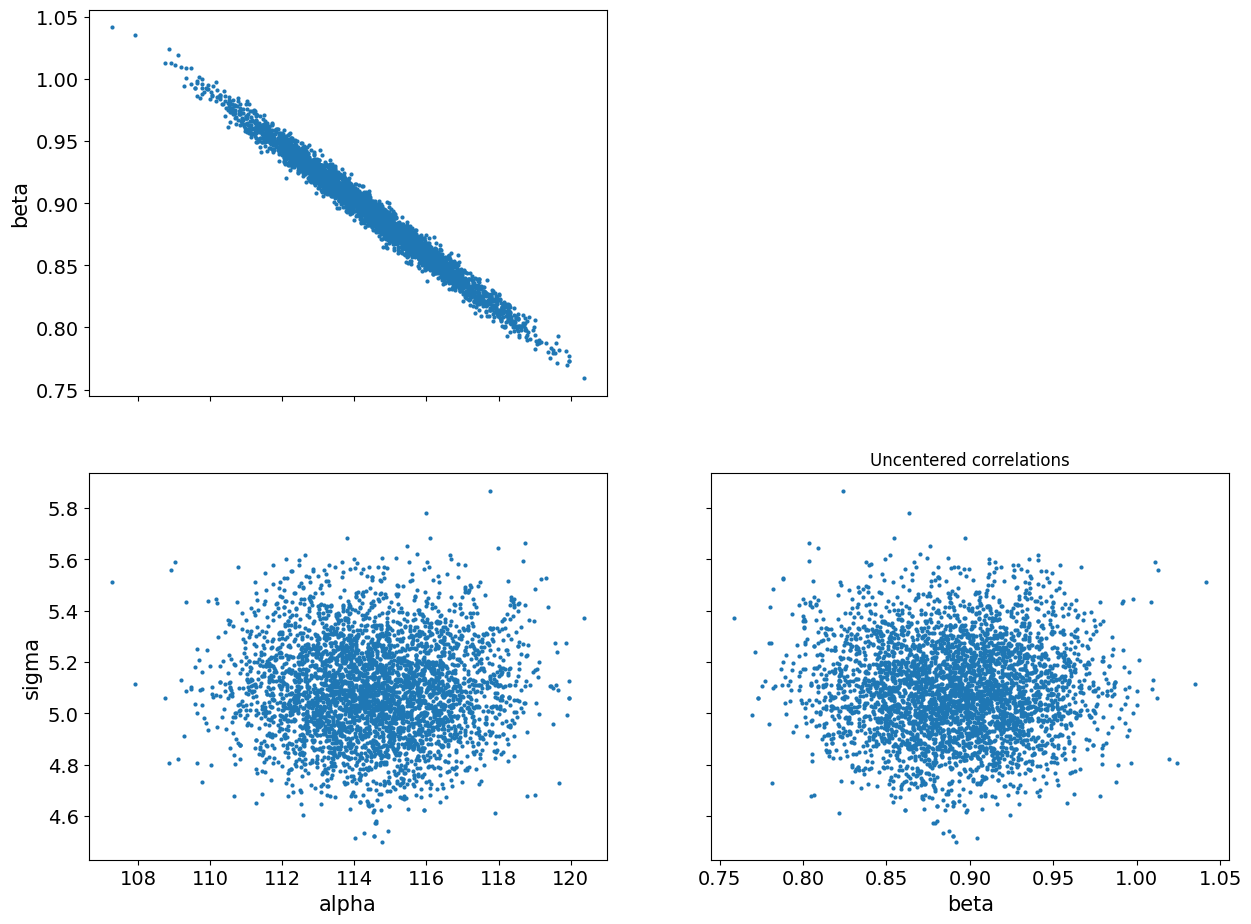

In [198]:
az.plot_pair(posterior_1)
plt.title("Centered correlations")
plt.show()
az.plot_pair(posterior_2)
plt.title("Uncentered correlations")
plt.show()

when plotting the posterior distributions, the alpha values are quite different, as expected. This is because when centering, its easier to set an intuitive prior for alpha : alpha is the expected height for the expected weight. This is called "centering". In the uncentered data, alpha and beta are heavily correlated (negatively) as seen in the pairplot. This makes it harder for the sample to converge.

in uncentered data, alpha represents mean height when weight is zero (?)


<Axes: xlabel='height'>

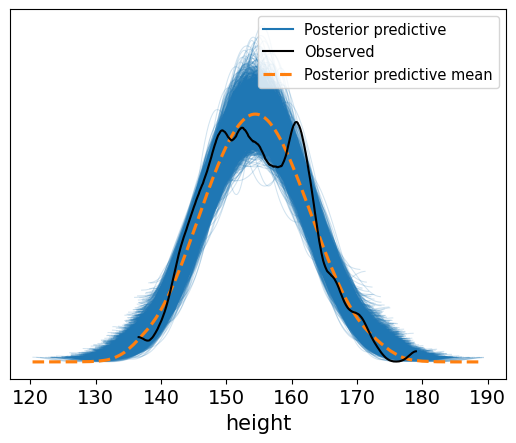

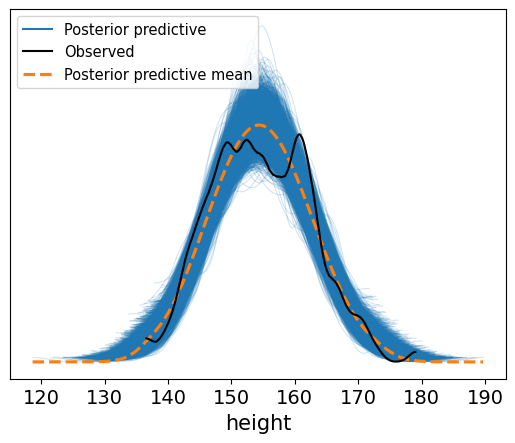

In [199]:
az.plot_ppc(posterior_pred_1)
az.plot_ppc(posterior_pred_2)

<Axes: >

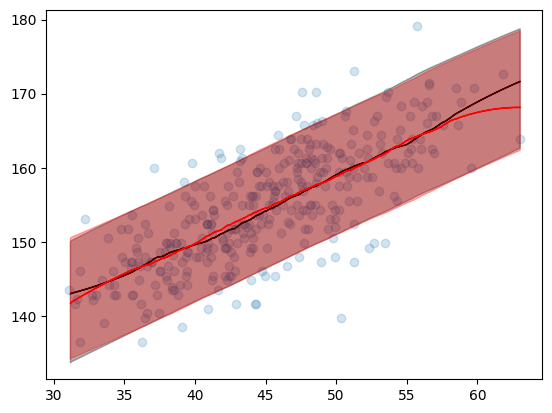

In [205]:
plt.scatter(df["weight"], df["height"], alpha=0.2)


az.plot_hdi(
    df["weight"],
    posterior_pred_1.posterior_predictive["height"],
    color="black",
    fill_kwargs=dict(alpha=0.3),
    hdi_prob=0.89,
)
az.plot_hdi(
    df["weight"],
    posterior_pred_1.posterior_predictive["height"],
    color="black",
    fill_kwargs=dict(alpha=1),
    hdi_prob=0.005,
)


az.plot_hdi(
    df["weight"],
    posterior_pred_2.posterior_predictive["height"],
    color="red",
    fill_kwargs=dict(alpha=0.3),
    hdi_prob=0.89,
)
az.plot_hdi(
    df["weight"],
    posterior_pred_2.posterior_predictive["height"],
    color="red",
    fill_kwargs=dict(alpha=1),
    hdi_prob=0.005,
)

the posterior predictive distributions seem to be the same, though!


## 4m8


In [206]:
blossom_data = pd.read_csv("./data/cherry_blossoms.csv", sep=";")[["doy", "year"]]
blossom_data = blossom_data.dropna()

Sampling: [alpha, beta1, beta10, beta11, beta12, beta13, beta14, beta15, beta16, beta17, beta2, beta3, beta4, beta5, beta6, beta7, beta8, beta9, doy, sigma]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta1, beta2, beta3, beta4, beta5, beta6, beta7, beta8, beta9, beta10, beta11, beta12, beta13, beta14, beta15, beta16, beta17, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
Sampling: [doy]


Output()

<Axes: >

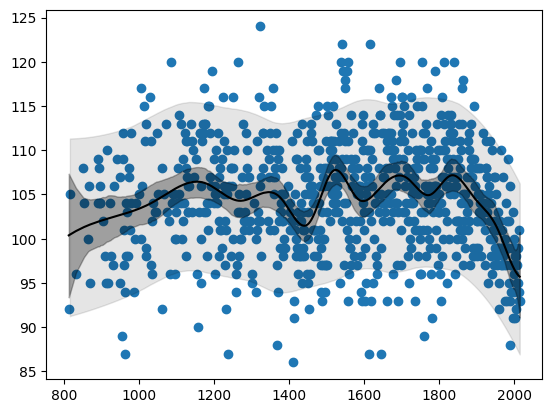

In [207]:
# original
num_knots = 15
knot_list = np.quantile(blossom_data["year"], q=np.linspace(0, 1, num=num_knots))

B = get_spline_basis(
    blossom_data["year"],
    knots=knot_list[1:-1],
    degree=3,
    intercept=True,
)

with pm.Model() as spline_model:
    alpha = pm.Normal("alpha", mu=100, sigma=10)

    betas = []
    for i in range(B.shape[-1]):
        betas.append(pm.Normal(f"beta{i+1}", mu=0, sigma=10))

    mu = alpha
    for i, b in enumerate(betas):
        mu += b * B[:, i]

    sigma = pm.Exponential("sigma", 1)

    doy = pm.Normal("doy", mu=mu, sigma=sigma, observed=blossom_data["doy"])
    prior = pm.sample_prior_predictive()
    posterior = pm.sample()
    posterior_pred = pm.sample_posterior_predictive(samples_inference)


# compute posterior dist of mean of doy(not of the doy)
posterior_param_samples = np.array(
    list(posterior.posterior.sel(chain=0).data_vars.values())
)
alpha = posterior_param_samples[0, :]
betas = posterior_param_samples[1:-1, :]
mus = []
for i in range(len(blossom_data["year"])):
    model_inp = B[i, :]
    mu_dist = alpha.copy()  # important to create a deep copy here
    for j in range(betas.shape[0]):
        mu_dist += betas[j, :] * model_inp[j]
    mus.append(mu_dist)
mus = np.array(mus)

# plot
plt.scatter(blossom_data["year"], blossom_data["doy"])
plt.plot(blossom_data["year"], mus.mean(axis=1), c="black")
pred_interval = 0.97
x = (1 - pred_interval) / 2
plt.fill_between(
    blossom_data["year"],
    np.quantile(mus, x, axis=1),
    np.quantile(mus, pred_interval + x, axis=1),
    alpha=0.3,
    color="black",
)
az.plot_hdi(
    blossom_data["year"],
    posterior_pred.posterior_predictive["doy"],
    color="black",
    fill_kwargs=dict(alpha=0.1),
    hdi_prob=0.89,
)


In [208]:
# more knots - it got more bendy and curvy, and HDI became broader at the end?
num_knots = 25
knot_list = np.quantile(blossom_data["year"], q=np.linspace(0, 1, num=num_knots))

B = get_spline_basis(
    blossom_data["year"],
    knots=knot_list[1:-1],
    degree=3,
    intercept=True,
)

with pm.Model() as spline_model:
    alpha = pm.Normal("alpha", mu=100, sigma=10)

    betas = []
    for i in range(B.shape[-1]):
        betas.append(pm.Normal(f"beta{i+1}", mu=0, sigma=10))

    mu = alpha
    for i, b in enumerate(betas):
        mu += b * B[:, i]

    sigma = pm.Exponential("sigma", 1)

    doy = pm.Normal("doy", mu=mu, sigma=sigma, observed=blossom_data["doy"])
    prior = pm.sample_prior_predictive()
    posterior = pm.sample()
    posterior_pred = pm.sample_posterior_predictive(samples_inference)


# compute posterior dist of mean of doy(not of the doy)
posterior_param_samples = np.array(
    list(posterior.posterior.sel(chain=0).data_vars.values())
)
alpha = posterior_param_samples[0, :]
betas = posterior_param_samples[1:-1, :]
mus = []
for i in range(len(blossom_data["year"])):
    model_inp = B[i, :]
    mu_dist = alpha.copy()  # important to create a deep copy here
    for j in range(betas.shape[0]):
        mu_dist += betas[j, :] * model_inp[j]
    mus.append(mu_dist)
mus = np.array(mus)

# plot
plt.scatter(blossom_data["year"], blossom_data["doy"])
plt.plot(blossom_data["year"], mus.mean(axis=1), c="black")
pred_interval = 0.97
x = (1 - pred_interval) / 2
plt.fill_between(
    blossom_data["year"],
    np.quantile(mus, x, axis=1),
    np.quantile(mus, pred_interval + x, axis=1),
    alpha=0.3,
    color="black",
)
az.plot_hdi(
    blossom_data["year"],
    posterior_pred.posterior_predictive["doy"],
    color="black",
    fill_kwargs=dict(alpha=0.1),
    hdi_prob=0.89,
)


Sampling: [alpha, beta1, beta10, beta11, beta12, beta13, beta14, beta15, beta16, beta17, beta18, beta19, beta2, beta20, beta21, beta22, beta23, beta24, beta25, beta26, beta27, beta3, beta4, beta5, beta6, beta7, beta8, beta9, doy, sigma]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta1, beta2, beta3, beta4, beta5, beta6, beta7, beta8, beta9, beta10, beta11, beta12, beta13, beta14, beta15, beta16, beta17, beta18, beta19, beta20, beta21, beta22, beta23, beta24, beta25, beta26, beta27, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
Sampling: [beta18, beta19, beta20, beta21, beta22, beta23, beta24, beta25, beta26, beta27, doy]


Output()

<Axes: >

Sampling: [alpha, beta1, beta10, beta11, beta12, beta13, beta14, beta15, beta16, beta17, beta18, beta19, beta2, beta20, beta21, beta22, beta23, beta24, beta25, beta26, beta27, beta3, beta4, beta5, beta6, beta7, beta8, beta9, doy, sigma]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta1, beta2, beta3, beta4, beta5, beta6, beta7, beta8, beta9, beta10, beta11, beta12, beta13, beta14, beta15, beta16, beta17, beta18, beta19, beta20, beta21, beta22, beta23, beta24, beta25, beta26, beta27, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [beta18, beta19, beta20, beta21, beta22, beta23, beta24, beta25, beta26, beta27, doy]


Output()

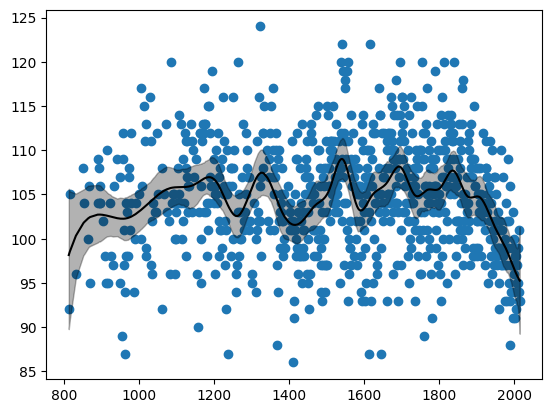

In [212]:
# more knots and bigger sd for dist
# seems same as the effect more knots had, bigger var at the end
num_knots = 25
knot_list = np.quantile(blossom_data["year"], q=np.linspace(0, 1, num=num_knots))

B = get_spline_basis(
    blossom_data["year"],
    knots=knot_list[1:-1],
    degree=3,
    intercept=True,
)

with pm.Model() as spline_model:
    alpha = pm.Normal("alpha", mu=100, sigma=10)

    betas = []
    for i in range(B.shape[-1]):
        betas.append(pm.Normal(f"beta{i+1}", mu=0, sigma=100))

    mu = alpha
    for i, b in enumerate(betas):
        mu += b * B[:, i]

    sigma = pm.Exponential("sigma", 1)

    doy = pm.Normal("doy", mu=mu, sigma=sigma, observed=blossom_data["doy"])
    prior = pm.sample_prior_predictive()
    posterior = pm.sample()
    posterior_pred = pm.sample_posterior_predictive(samples_inference)


# compute posterior dist of mean of doy(not of the doy)
posterior_param_samples = np.array(
    list(posterior.posterior.sel(chain=0).data_vars.values())
)
alpha = posterior_param_samples[0, :]
betas = posterior_param_samples[1:-1, :]
mus = []
for i in range(len(blossom_data["year"])):
    model_inp = B[i, :]
    mu_dist = alpha.copy()  # important to create a deep copy here
    for j in range(betas.shape[0]):
        mu_dist += betas[j, :] * model_inp[j]
    mus.append(mu_dist)
mus = np.array(mus)

# plot
plt.scatter(blossom_data["year"], blossom_data["doy"])
plt.plot(blossom_data["year"], mus.mean(axis=1), c="black")
pred_interval = 0.97
x = (1 - pred_interval) / 2
plt.fill_between(
    blossom_data["year"],
    np.quantile(mus, x, axis=1),
    np.quantile(mus, pred_interval + x, axis=1),
    alpha=0.3,
    color="black",
)
# az.plot_hdi(
#     blossom_data["year"],
#     posterior_pred.posterior_predictive["doy"],
#     color="black",
#     fill_kwargs=dict(alpha=0.1),
#     hdi_prob=0.89,
# )


> soln but i didnt reproduce: number of knots makes it more wiggly but just upto a point. this is because the std dev of coeffs controls it. if you increase that, then it can get more wiggly.


## 4h1


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [height]


Output()

<Axes: >

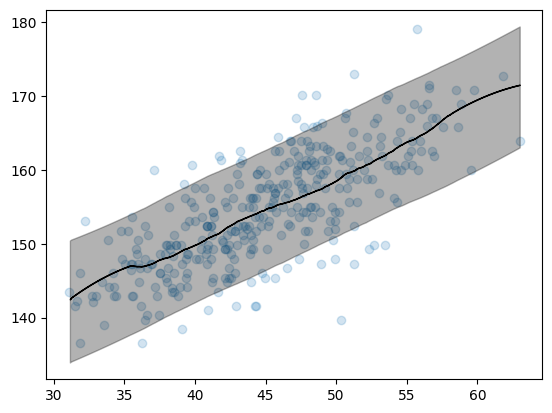

In [215]:
df = pd.read_csv("./data/Howell1.csv", sep=";")
df = df[df["age"] >= 18]

with pm.Model() as model_4h1:
    alpha = pm.Normal("alpha", mu=178, sigma=20)
    beta = pm.Normal("beta", mu=0, sigma=10)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = alpha + beta * (df["weight"] - df["weight"].mean())
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=df["height"])
    posterior_1 = pm.sample()
    posterior_pred_1 = pm.sample_posterior_predictive(posterior_1)

plt.scatter(df["weight"], df["height"], alpha=0.2)


az.plot_hdi(
    df["weight"],
    posterior_pred_1.posterior_predictive["height"],
    color="black",
    fill_kwargs=dict(alpha=0.3),
    hdi_prob=0.89,
)
az.plot_hdi(
    df["weight"],
    posterior_pred_1.posterior_predictive["height"],
    color="black",
    fill_kwargs=dict(alpha=1),
    hdi_prob=0.005,
)


In [222]:
alpha = posterior_1.posterior["alpha"].values.flatten()
beta = posterior_1.posterior["beta"].values.flatten()
sigma = posterior_1.posterior["sigma"].values.flatten()

Attempt 1: **wrong**


In [234]:
weights_to_test = np.array([46.95, 43.72, 64.78, 32.59, 54.63])

means = np.empty((len(weights_to_test), len(alpha)))
for i, w in enumerate(weights_to_test):
    m = alpha + beta * (w - df["weight"].mean())
    means[i, :] = m

p_int = 0.89
x = (1 - p_int) / 2
expected_heights = np.mean(means, axis=1)

low = np.quantile(means, x, axis=1)
upp = np.quantile(means, p_int + x, axis=1)

# Display the dataframe
df_results = pd.DataFrame(
    {
        "weight": weights_to_test,
        "expected height": expected_heights,
        "89p low": low,
        "89p high": upp,
    }
)
display(df_results)

# Create plot
plt.figure(figsize=(10, 6))
plt.errorbar(
    weights_to_test,
    expected_heights,
    yerr=[expected_heights - low, upp - expected_heights],
    fmt="o",
    capsize=5,
    capthick=2,
    elinewidth=2,
    label="89% Interval",
)
plt.scatter(
    weights_to_test, expected_heights, color="red", zorder=10, label="Expected Height"
)

plt.xlabel("Weight")
plt.ylabel("Height")
plt.title("Expected Heights with 89% prediction Intervals")
plt.legend()
plt.grid(True, alpha=0.3)

weight  expected height     89p low    89p high
0   46.95       156.380387  155.939156  156.809342
1   43.72       153.459864  153.036997  153.887497
2   64.78       172.502033  171.077924  173.961473
3   32.59       143.396268  142.465602  144.329756
4   54.63       163.324540  162.523822  164.129224

that was wrong because the question implied the 89% uncertainty in height, not _the mean of the height_.


weight  expected height     89p low    89p high
0   46.95       156.482065  148.320909  164.308848
1   43.72       153.536673  145.505115  161.615810
2   64.78       172.501120  164.127673  180.340106
3   32.59       143.370585  134.984023  151.649665
4   54.63       163.274922  155.258092  171.854064

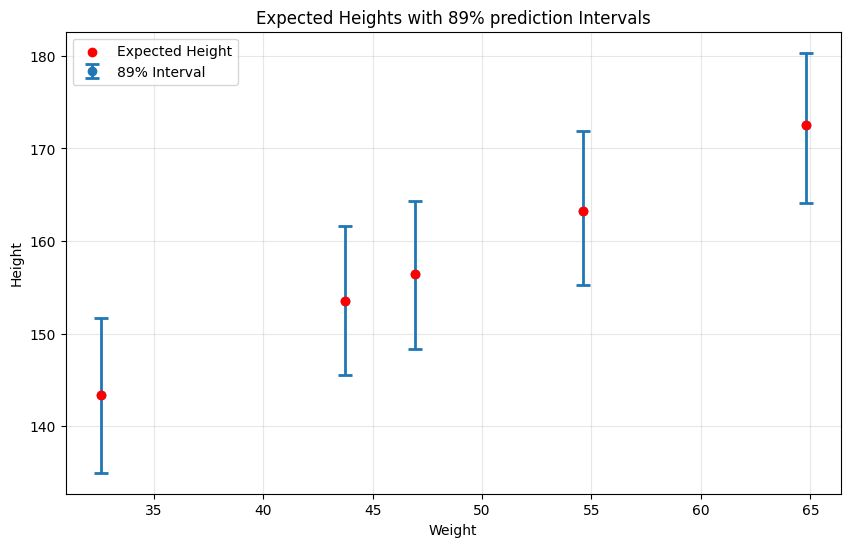

In [237]:
weights_to_test = np.array([46.95, 43.72, 64.78, 32.59, 54.63])

heights = np.empty((len(weights_to_test), len(alpha)))
for i, w in enumerate(weights_to_test):
    m = alpha + beta * (w - df["weight"].mean())
    # key step in this case: gets one sample from 4_000 normal distribution,
    # as described by 4000 mu's and 4000 sigma's
    h = np.random.normal(m, sigma)
    heights[i, :] = h

p_int = 0.89
x = (1 - p_int) / 2
expected_heights = np.mean(heights, axis=1)

low = np.quantile(heights, x, axis=1)
upp = np.quantile(heights, p_int + x, axis=1)

# Display the dataframe
df_results = pd.DataFrame(
    {
        "weight": weights_to_test,
        "expected height": expected_heights,
        "89p low": low,
        "89p high": upp,
    }
)
display(df_results)

# Create plot
plt.figure(figsize=(10, 6))
plt.errorbar(
    weights_to_test,
    expected_heights,
    yerr=[expected_heights - low, upp - expected_heights],
    fmt="o",
    capsize=5,
    capthick=2,
    elinewidth=2,
    label="89% Interval",
)
plt.scatter(
    weights_to_test, expected_heights, color="red", zorder=10, label="Expected Height"
)

plt.xlabel("Weight")
plt.ylabel("Height")
plt.title("Expected Heights with 89% prediction Intervals")
plt.legend()
plt.grid(True, alpha=0.3)

## 4h2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [height]


Output()

<Axes: >

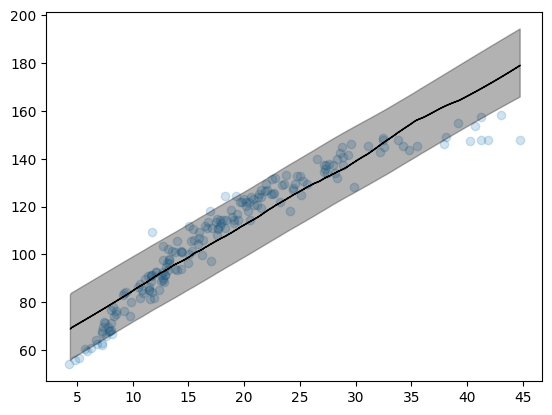

In [239]:
df = pd.read_csv("./data/Howell1.csv", sep=";")
df = df[df["age"] < 18]

with pm.Model() as model_4h2:
    alpha = pm.Normal("alpha", mu=178, sigma=20)
    beta = pm.Normal("beta", mu=0, sigma=10)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = alpha + beta * (df["weight"] - df["weight"].mean())
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=df["height"])
    posterior_1 = pm.sample()
    posterior_pred_1 = pm.sample_posterior_predictive(posterior_1)

plt.scatter(df["weight"], df["height"], alpha=0.2)


az.plot_hdi(
    df["weight"],
    posterior_pred_1.posterior_predictive["height"],
    color="black",
    fill_kwargs=dict(alpha=0.3),
    hdi_prob=0.89,
)
az.plot_hdi(
    df["weight"],
    posterior_pred_1.posterior_predictive["height"],
    color="black",
    fill_kwargs=dict(alpha=1),
    hdi_prob=0.005,
)

In [240]:
alpha = posterior_1.posterior["alpha"].values.flatten()
beta = posterior_1.posterior["beta"].values.flatten()
sigma = posterior_1.posterior["sigma"].values.flatten()

2.719723064736061


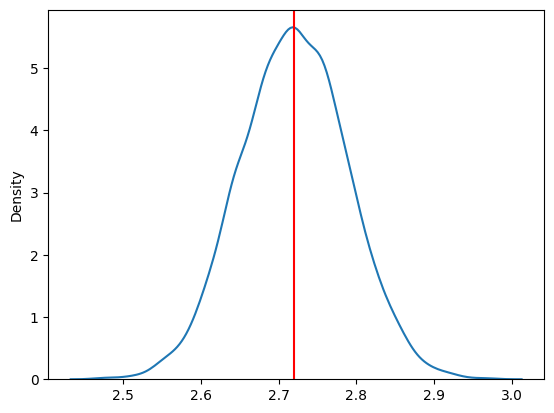

In [244]:
sns.kdeplot(beta)
mean = np.mean(beta)
print(mean)
plt.axvline(mean, c="r")

a : ~27.19 cm per 20 kg increase


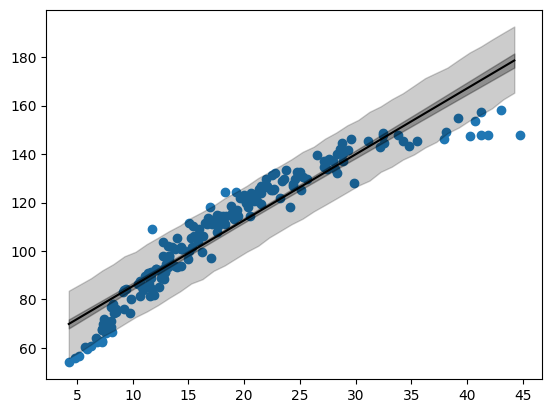

In [246]:
weights_to_test = np.arange(df["weight"].min(), df["weight"].max(), 1)
means = np.empty((len(weights_to_test), len(alpha)))
heights = np.empty((len(weights_to_test), len(alpha)))
for i, w in enumerate(weights_to_test):
    m = alpha + beta * (w - df["weight"].mean())
    h = np.random.normal(m, sigma)
    means[i, :] = m
    heights[i, :] = h

expected_mean = np.mean(means, axis=1)

low_mean = np.quantile(means, x, axis=1)
upp_mean = np.quantile(means, p_int + x, axis=1)

low_heights = np.quantile(heights, x, axis=1)
upp_heights = np.quantile(heights, p_int + x, axis=1)


plt.scatter(df["weight"], df["height"])
plt.plot(weights_to_test, expected_mean, c="black")
plt.fill_between(
    weights_to_test,
    low_mean,
    upp_mean,
    alpha=0.3,
    color="black",
)
plt.fill_between(
    weights_to_test,
    low_heights,
    upp_heights,
    alpha=0.2,
    color="black",
)

c: the linear assumption of the model concerns me - the data does not seem linear at all. model with some ability to model the curve would be good,, maybe a spline fit, or even a low order polynomial fit?

> solution adds on: there are many model options, what we are really after is some way to model the reduction in slope as the weight increases towards the end.


## 4h3


In [249]:
df = pd.read_csv("./data/Howell1.csv", sep=";")

with pm.Model() as model_4h3:
    alpha = pm.Normal("alpha", mu=178, sigma=20)
    beta = pm.Normal("beta", mu=0, sigma=10)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = alpha + beta * np.log(df["weight"])
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=df["height"])
    posterior_1 = pm.sample()
    posterior_pred_1 = pm.sample_posterior_predictive(posterior_1)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [height]


Output()

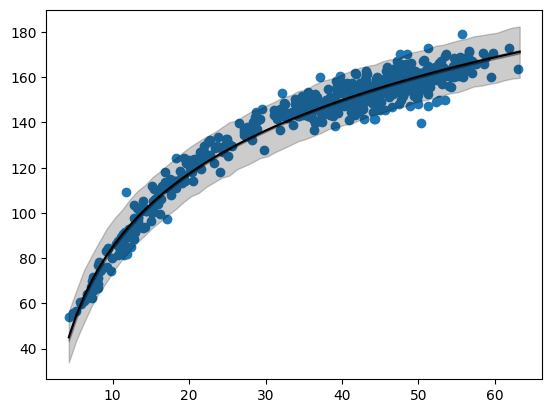

In [254]:
alpha = posterior_1.posterior["alpha"].values.flatten()
beta = posterior_1.posterior["beta"].values.flatten()
sigma = posterior_1.posterior["sigma"].values.flatten()


weights_to_test = np.arange(df["weight"].min(), df["weight"].max() + 1, 1)
means = np.empty((len(weights_to_test), len(alpha)))
heights = np.empty((len(weights_to_test), len(alpha)))
for i, w in enumerate(weights_to_test):
    m = alpha + beta * np.log(w)
    h = np.random.normal(m, sigma)
    means[i, :] = m
    heights[i, :] = h

expected_mean = np.mean(means, axis=1)

p_int = 0.97
x = (1 - p_int) / 2
low_mean = np.quantile(means, x, axis=1)
upp_mean = np.quantile(means, p_int + x, axis=1)

low_heights = np.quantile(heights, x, axis=1)
upp_heights = np.quantile(heights, p_int + x, axis=1)


plt.scatter(df["weight"], df["height"])
plt.plot(weights_to_test, expected_mean, c="black")
plt.fill_between(
    weights_to_test,
    low_mean,
    upp_mean,
    alpha=0.3,
    color="black",
)
plt.fill_between(
    weights_to_test,
    low_heights,
    upp_heights,
    alpha=0.2,
    color="black",
)

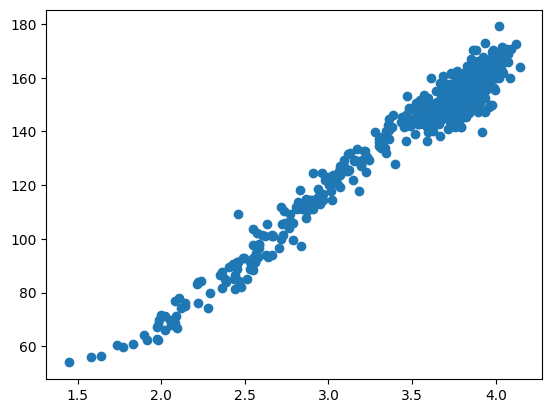

In [256]:
# why does the log-model work? well...
plt.scatter(np.log(df["weight"]), df["height"])
# it's linear in the log space!

## 4H4


Sampling: [alpha, beta1, beta2, height, sigma]


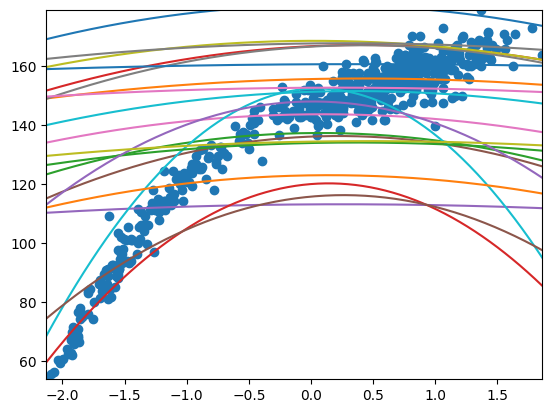

In [300]:
df = pd.read_csv("./data/Howell1.csv", sep=";")
w_std = (df["weight"] - df["weight"].mean()) / df["weight"].std()
with pm.Model() as poly_model:
    alpha = pm.Normal("alpha", mu=150, sigma=20)
    beta1 = pm.LogNormal("beta1", mu=0, sigma=1)
    beta2 = pm.LogNormal("beta2", mu=1, sigma=1)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = alpha + beta1 * w_std - beta2 * (w_std**2)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=df["height"])
    samples_prior = pm.sample_prior_predictive()

plt.scatter(w_std, df["height"])
plt.xlim(w_std.min(), w_std.max())
plt.ylim(df["height"].min(), df["height"].max())


alpha = samples_prior.prior.sel(chain=0)["alpha"].values.flatten()
beta1 = samples_prior.prior.sel(chain=0)["beta1"].values.flatten()
beta2 = samples_prior.prior.sel(chain=0)["beta2"].values.flatten()

w_test = np.linspace(w_std.min(), w_std.max(), 200)

for i in range(20):
    curve = alpha[i] + beta1[i] * w_test - beta2[i] * (w_test**2)
    plt.plot(w_test, curve)


note that the x axis is the standardised weight, so that the alpha prior makes some sense. When we previously fit it for fun, we did not pay much attention to it (and it didnt make a difference in this case), but keep that in mind, because there will be cases where setting priors are more important.


b1 and b1 will be correlated for the family of reasonable curves - but here, we assume they are independant in the priors, as we independantly set distributions for them. still getting them to some reasonable range is nice.

> from soln: These (uniform) prior curves actually strongly favor explosive growth or shrinkage near the mean. This is a general phenomenon with “flat” priors: Once the predictor is complicated, “flat” does not imply “no relationship.”


# 4h5


Correlation between temperature and day of year: -0.32697570343614923


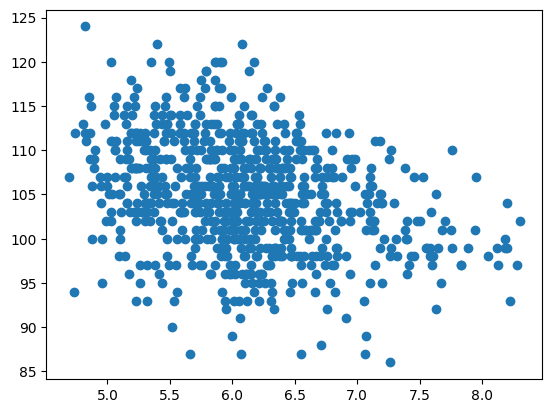

In [341]:
df = pd.read_csv("./data/cherry_blossoms.csv", sep=";")
df = df[["temp", "doy"]].dropna()
df = df.sort_values("temp")

print(f"Correlation between temperature and day of year: {df['temp'].corr(df['doy'])}")
plt.scatter(df["temp"], df["doy"])

In [330]:
len(df)

787

In [316]:
def get_polynomial_basis(x, degree=1):
    return np.c_[*[x ** (i + 1) for i in range(degree)]]

In [342]:
num_knots = 30

temp_std = (df["temp"] - df["temp"].mean()) / df["temp"].std()
temp = temp_std

knot_list = np.quantile(temp, np.linspace(0, 1, num_knots))
B = get_spline_basis(temp, knot_list, 3, intercept=True)
# B = get_polynomial_basis(temp, degree=1)
with pm.Model() as model_4h5:
    sigma = pm.Exponential("sigma", 1)
    alpha = pm.Normal("alpha", 100, 10)
    betas = []
    for i in range(B.shape[-1]):
        betas.append(pm.Normal(f"beta{i}", 0, 10))

    mu = alpha
    for i, b in enumerate(betas):
        mu += b * B[:, i]
    doy = pm.Normal("doy", mu, sigma, observed=df["doy"])
    prior_pred = pm.sample_prior_predictive()
    posterior = pm.sample()
    posterior_pred = pm.sample_posterior_predictive(posterior)


Sampling: [alpha, beta0, beta1, beta10, beta11, beta12, beta13, beta14, beta15, beta16, beta17, beta18, beta19, beta2, beta20, beta21, beta22, beta23, beta24, beta25, beta26, beta27, beta28, beta29, beta3, beta30, beta31, beta32, beta33, beta4, beta5, beta6, beta7, beta8, beta9, doy, sigma]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta0, beta1, beta2, beta3, beta4, beta5, beta6, beta7, beta8, beta9, beta10, beta11, beta12, beta13, beta14, beta15, beta16, beta17, beta18, beta19, beta20, beta21, beta22, beta23, beta24, beta25, beta26, beta27, beta28, beta29, beta30, beta31, beta32, beta33]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
Sampling: [doy]


Output()

shape of a single mu dist is  (1000,)
(787, 1000)


<Axes: >

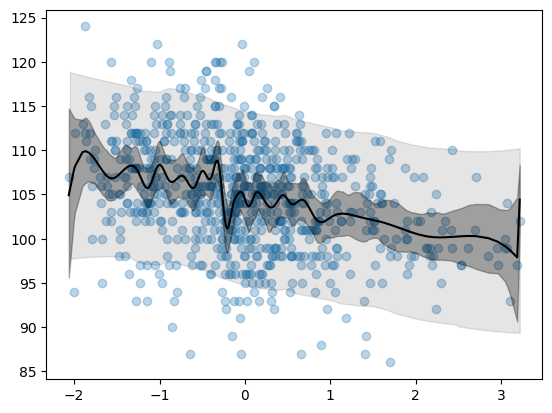

In [348]:
posterior_param_samples = np.array(
    list(posterior.posterior.sel(chain=0).data_vars.values())
)
alpha = posterior_param_samples[0, :]
betas = posterior_param_samples[1:-1, :]
mus = []

for i in range(len(temp)):
    model_inp = B[i, :]
    mu_dist = alpha.copy()  # important to create a deep copy here
    for j in range(betas.shape[0]):
        mu_dist += betas[j, :] * model_inp[j]
    if i == 0:
        print("shape of a single mu dist is ", mu_dist.shape)
    mus.append(mu_dist)

mus = np.array(mus)
print(mus.shape)

plt.scatter(temp, df["doy"], alpha=0.3)

# plot samples
# for i in np.random.randint(0, mus.shape[-1], size=20):
#     plt.plot(temp, mus[:, i], c="black", alpha=0.3)

plt.plot(temp, mus.mean(axis=1), c="black")
plt.fill_between(
    temp,
    np.quantile(mus, x, axis=1),
    np.quantile(mus, pred_interval + x, axis=1),
    alpha=0.3,
    color="black",
)


az.plot_hdi(
    temp,
    posterior_pred.posterior_predictive["doy"],
    color="black",
    fill_kwargs=dict(alpha=0.1),
    hdi_prob=0.90,
)
# az.plot_hdi(
#     temp,
#     posterior_pred.posterior_predictive["doy"],
#     color="black",
#     fill_kwargs=dict(alpha=1),
#     hdi_prob=0.005,
# )

In [345]:
## parameter densities
# axes = az.plot_density(
#     [posterior],
#     shade=0.2,
# )

<Axes: xlabel='doy'>

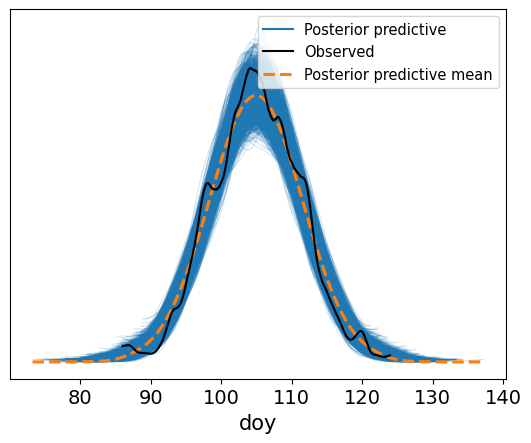

In [346]:
# how well does temperature predict blossom trend?
# let's look at the posterior predictive distribution

az.plot_ppc(posterior_pred)

despite the model used, the fit seems to be similar - linear, so we settle on a linear model. there appears to be a slight negative correlation of the day of blossom with temperature - higher temperatures lead to earlier blossom times.

> while it is linear, the solution uses a spline - let's play with it and try to get some wiggles

The spline fit with lot of knots looks wiggle - note, the hdi for the doy was still linear, but hwen i plotted the expected means and the mean distribution of the heights, it looked wiggly. Also, I had to sort by values of temperature, otherwise the plots were messed up.


## 4h6


Sampling: [alpha, beta1, beta10, beta11, beta12, beta13, beta14, beta15, beta16, beta17, beta2, beta3, beta4, beta5, beta6, beta7, beta8, beta9, doy, sigma]


shape of a single mu dist is  (500,)


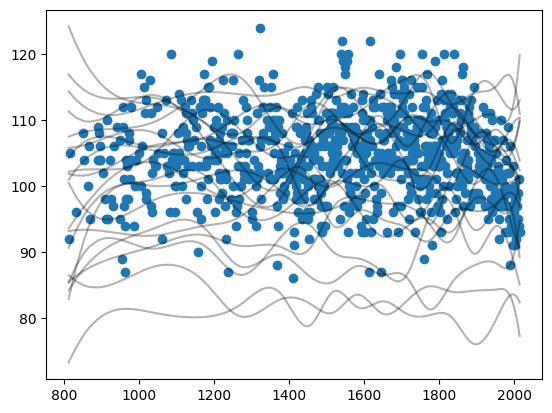

In [361]:
blossom_data = pd.read_csv("./data/cherry_blossoms.csv", sep=";")[["doy", "year"]]
blossom_data = blossom_data.dropna()
num_knots = 15
knot_list = np.quantile(blossom_data["year"], q=np.linspace(0, 1, num=num_knots))
B = get_spline_basis(
    blossom_data["year"],
    knots=knot_list[1:-1],
    degree=3,
    intercept=True,
)
with pm.Model() as spline_model:
    alpha = pm.Normal("alpha", mu=100, sigma=10)

    betas = []
    for i in range(B.shape[-1]):
        betas.append(pm.Normal(f"beta{i+1}", mu=0, sigma=5))

    mu = alpha
    for i, b in enumerate(betas):
        mu += b * B[:, i]

    # eponential is a good prior for scale, since it must be positive
    sigma = pm.Exponential("sigma", 1)

    doy = pm.Normal("doy", mu=mu, sigma=sigma, observed=blossom_data["doy"])
    prior = pm.sample_prior_predictive()
    # posterior = pm.sample()
    # posterior_pred = pm.sample_posterior_predictive(samples_inference)
prior_param_samples = np.array(list(prior.prior.sel(chain=0).data_vars.values()))

alpha = prior_param_samples[0, :]
betas = prior_param_samples[1:-1, :]
mus = []
for i in range(len(blossom_data["year"])):
    model_inp = B[i, :]
    mu_dist = alpha.copy()  # important to create a deep copy here
    for j in range(betas.shape[0]):
        mu_dist += betas[j, :] * model_inp[j]
    if i == 0:
        print("shape of a single mu dist is ", mu_dist.shape)
    mus.append(mu_dist)

mus = np.array(mus)


plt.scatter(blossom_data["year"], blossom_data["doy"])
# plt.xlim(blossom_data["year"].min(), blossom_data["year"].max())
# plt.ylim(blossom_data["doy"].min(), blossom_data["doy"].max())

for i in np.random.randint(0, mus.shape[-1], size=20):
    plt.plot(blossom_data["year"], mus[:, i], c="black", alpha=0.3)

the std dev in the basis seems to control the magnitude of the curves in the splines - how far they're allowed to curve/bend

> a very tight prior means that a lot of evidence is needed to introduce local wiggle


# 4H7


In [407]:
blossom_data = pd.read_csv("./data/cherry_blossoms.csv", sep=";")[["doy", "year"]]
blossom_data = blossom_data.dropna()
num_knots = 15
knot_list = np.quantile(blossom_data["year"], q=np.linspace(0, 1, num=num_knots))
B = get_spline_basis(
    blossom_data["year"],
    knots=knot_list[1:-1],
    degree=3,
    intercept=True,
)
with pm.Model() as spline_model:
    alpha = pm.Normal("alpha", mu=100, sigma=10)

    betas = []
    for i in range(B.shape[-1]):
        betas.append(pm.Normal(f"beta{i+1}", mu=0, sigma=5))

    mu = alpha
    for i, b in enumerate(betas):
        mu += b * B[:, i]

    # eponential is a good prior for scale, since it must be positive
    sigma = pm.Exponential("sigma", 1)

    doy = pm.Normal("doy", mu=mu, sigma=sigma, observed=blossom_data["doy"])
    prior = pm.sample_prior_predictive()
    posterior = pm.sample()
    posterior_pred = pm.sample_posterior_predictive(samples_inference)


Sampling: [alpha, beta1, beta10, beta11, beta12, beta13, beta14, beta15, beta16, beta17, beta2, beta3, beta4, beta5, beta6, beta7, beta8, beta9, doy, sigma]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta1, beta2, beta3, beta4, beta5, beta6, beta7, beta8, beta9, beta10, beta11, beta12, beta13, beta14, beta15, beta16, beta17, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
Sampling: [doy]


Output()

center priors with fixed intercept


Sampling: [beta1, beta10, beta11, beta12, beta13, beta14, beta15, beta16, beta17, beta2, beta3, beta4, beta5, beta6, beta7, beta8, beta9, doy, sigma]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta1, beta2, beta3, beta4, beta5, beta6, beta7, beta8, beta9, beta10, beta11, beta12, beta13, beta14, beta15, beta16, beta17, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
Sampling: [doy]


Output()

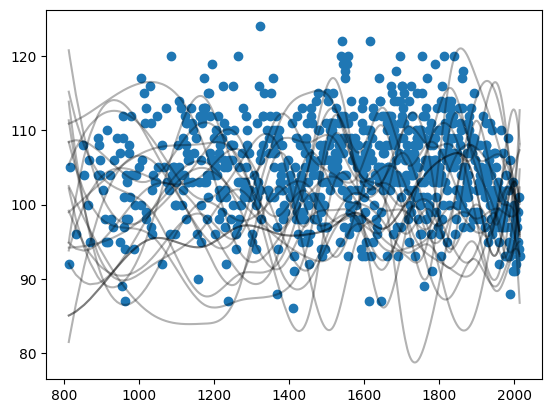

In [426]:
num_knots = 15
knot_list = np.quantile(blossom_data["year"], q=np.linspace(0, 1, num=num_knots))
B = get_spline_basis(
    blossom_data["year"],
    knots=knot_list[1:-1],
    degree=3,
    intercept=True,
)
with pm.Model() as spline_model2:
    # alpha = pm.Normal("alpha", mu=100, sigma=10)

    # dist = pm.Normal('dist',100,0)
    betas = []
    for i in range(B.shape[-1]):
        betas.append(pm.Normal(f"beta{i+1}", mu=0, sigma=10))

    mu = 100
    for i, b in enumerate(betas):
        mu += b * B[:, i]

    # eponential is a good prior for scale, since it must be positive
    sigma = pm.Exponential("sigma", 1)

    doy = pm.Normal("doy", mu=mu, sigma=sigma, observed=blossom_data["doy"])
    prior2 = pm.sample_prior_predictive()
    posterior2 = pm.sample()
    posterior_pred2 = pm.sample_posterior_predictive(samples_inference)

# plot prior predictive
prior_param_samples = np.array(list(prior2.prior.sel(chain=0).data_vars.values()))

betas = prior_param_samples[:-1, :]
mus = []
for i in range(len(blossom_data["year"])):
    model_inp = B[i, :]
    mu_dist = 100
    for j in range(betas.shape[0]):
        mu_dist += betas[j, :] * model_inp[j]
    mus.append(mu_dist)

mus = np.array(mus)


plt.scatter(blossom_data["year"], blossom_data["doy"])
# plt.xlim(blossom_data["year"].min(), blossom_data["year"].max())
# plt.ylim(blossom_data["doy"].min(), blossom_data["doy"].max())

for i in np.random.randint(0, mus.shape[-1], size=20):
    plt.plot(blossom_data["year"], mus[:, i], c="black", alpha=0.3)

Center priors in normal distribution

> important! turns out i was assiging diff probability distributions to wach basis weight, when they all come from the _same_ normal distribution, w. The code below reflects that update, and only in this scenario does the normal mean updating work to change the intercept.


Sampling: [doy, sigma, w]
Initializing NUTS using jitter+adapt_diag...


(827, 17)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [doy, w]


Output()

(500, 17)
(827, 500)


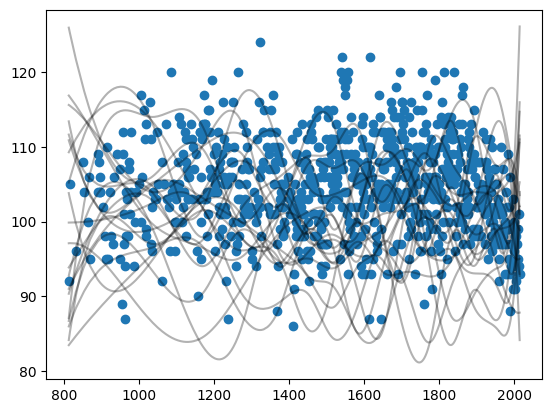

In [481]:
blossom_data = pd.read_csv("./data/cherry_blossoms.csv", sep=";")[["doy", "year"]]
blossom_data = blossom_data.dropna()
blossom_data = blossom_data.sort_values("year")


num_knots = 15
knot_list = np.quantile(blossom_data["year"], q=np.linspace(0, 1, num=num_knots))
B = get_spline_basis(
    blossom_data["year"],
    knots=knot_list[1:-1],
    degree=3,
    intercept=True,
)
print(B.shape)
with pm.Model() as spline_model3:
    w = pm.Normal("w", 100, 10, shape=B.shape[-1])

    mu = pm.math.dot(B, w)

    # eponential is a good prior for scale, since it must be positive
    sigma = pm.Exponential("sigma", 1)

    doy = pm.Normal("doy", mu=mu, sigma=sigma, observed=blossom_data["doy"])
    prior3 = pm.sample_prior_predictive()
    posterior3 = pm.sample()
    posterior_pred3 = pm.sample_posterior_predictive(samples_inference)

# plot prior predictive
prior_param_samples = np.array(list(prior3.prior.sel(chain=0)["w"].values))
print(prior_param_samples.shape)
betas = prior_param_samples
mus = []
for i in range(len(blossom_data["year"])):
    model_inp = B[i, :]
    mu_dist = 0
    for j in range(betas.shape[-1]):
        mu_dist += betas[:, j] * model_inp[j]
    mus.append(mu_dist)

mus = np.array(mus)
print(mus.shape)


plt.scatter(blossom_data["year"], blossom_data["doy"])

for i in np.random.randint(0, mus.shape[-1], size=20):
    plt.plot(blossom_data["year"], mus[:, i], c="black", alpha=0.3)

shape of a single mu dist is  (1000,)
shape of a single mu dist is  (1000,)
(1000, 17)
(827, 1000)


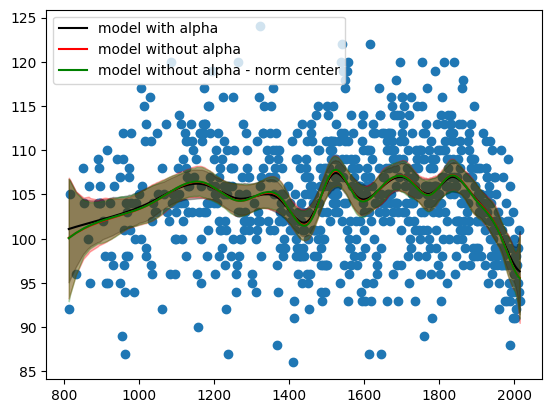

In [487]:
prior_param_samples = np.array(
    list(posterior.posterior.sel(chain=0).data_vars.values())
)

alpha = prior_param_samples[0, :]
betas = prior_param_samples[1:-1, :]
mus = []
for i in range(len(blossom_data["year"])):
    model_inp = B[i, :]
    mu_dist = alpha.copy()  # important to create a deep copy here
    for j in range(betas.shape[0]):
        mu_dist += betas[j, :] * model_inp[j]
    if i == 0:
        print("shape of a single mu dist is ", mu_dist.shape)
    mus.append(mu_dist)

mus = np.array(mus)


plt.scatter(blossom_data["year"], blossom_data["doy"])
# plt.xlim(blossom_data["year"].min(), blossom_data["year"].max())
# plt.ylim(blossom_data["doy"].min(), blossom_data["doy"].max())
plt.plot(blossom_data["year"], mus.mean(axis=1), c="black", label="model with alpha")

pred_interval = 0.97
x = (1 - pred_interval) / 2
plt.fill_between(
    blossom_data["year"],
    np.quantile(mus, x, axis=1),
    np.quantile(mus, pred_interval + x, axis=1),
    alpha=0.3,
    color="black",
)


######
prior_param_samples = np.array(
    list(posterior2.posterior.sel(chain=0).data_vars.values())
)

betas = prior_param_samples[:-1, :]
mus = []
for i in range(len(blossom_data["year"])):
    model_inp = B[i, :]
    mu_dist = 100
    for j in range(betas.shape[0]):
        mu_dist += betas[j, :] * model_inp[j]
    if i == 0:
        print("shape of a single mu dist is ", mu_dist.shape)
    mus.append(mu_dist)

mus = np.array(mus)


plt.plot(blossom_data["year"], mus.mean(axis=1), c="red", label="model without alpha")

pred_interval = 0.97
x = (1 - pred_interval) / 2
plt.fill_between(
    blossom_data["year"],
    np.quantile(mus, x, axis=1),
    np.quantile(mus, pred_interval + x, axis=1),
    alpha=0.3,
    color="red",
)


###

######
prior_param_samples = np.array(list(posterior3.posterior.sel(chain=0)["w"].values))
print(prior_param_samples.shape)
betas = prior_param_samples
mus = []
for i in range(len(blossom_data["year"])):
    model_inp = B[i, :]
    mu_dist = 0
    for j in range(betas.shape[-1]):
        mu_dist += betas[:, j] * model_inp[j]
    mus.append(mu_dist)

mus = np.array(mus)
print(mus.shape)


plt.plot(
    blossom_data["year"],
    mus.mean(axis=1),
    c="green",
    label="model without alpha - norm center",
)

pred_interval = 0.97
x = (1 - pred_interval) / 2
plt.fill_between(
    blossom_data["year"],
    np.quantile(mus, x, axis=1),
    np.quantile(mus, pred_interval + x, axis=1),
    alpha=0.3,
    color="green",
)

plt.legend();

> the solution mentioned two methods - either put a fixed intercept to have reasonable priors, or center the weights somewhere else.

I fixed the intercept to be 100, but centering it in the normal distribution (like in the answer) somehow did not work.

update: that was because i was assigning the parameter values differently - one was a normal dist for each parameter (original), and the next was n_basis weights from the same normal distribution , multiplied and summed with a dot product.

> from claude: The shared distribution approach provides a form of "pooling" where information about one weight can inform the others, potentially leading to more stable estimates. The R code's intention is to say "all these weights should behave similarly" rather than "each weight is its own independent thing." The single distribution better captures this intent. The shared distribution acts as a form of soft regularization, helping prevent individual weights from taking on extreme values unless strongly supported by the data.

> This is why you might have seen different results between the two approaches - the shared distribution approach generally leads to more stable and theoretically appropriate results for this type of spline model.

This aspect of switching from individual distributions for parameters to the shared parameter form is not explained in the book.


# numpyro

jax+pyro


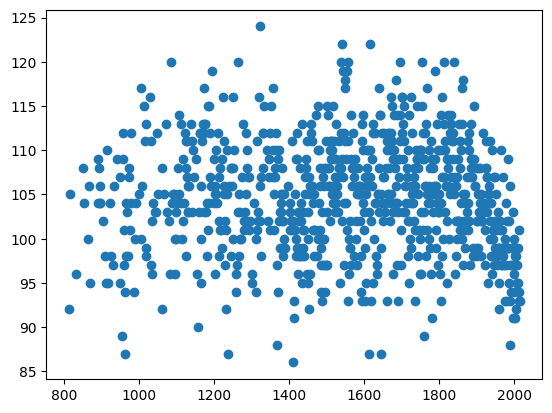

In [27]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import pandas as pd
from jax import random
from numpyro.infer import MCMC, NUTS, Predictive

blossom_data = pd.read_csv("./data/cherry_blossoms.csv", sep=";")[["doy", "year"]]
blossom_data = blossom_data.dropna()
blossom_data = blossom_data.sort_values("year")
plt.scatter(blossom_data["year"], blossom_data["doy"])

In [15]:
from scipy.interpolate import splev
import numpy as np


def get_spline_basis(x, knots: np.ndarray, degree: int, intercept: bool):
    """Logic from patsy : https://github.com/pydata/patsy/blob/master/patsy/splines.py"""
    order = degree + 1
    lower_bound = np.min(x)
    upper_bound = np.max(x)
    # we want duplicate values for the boundary knots usually.
    all_knots = np.concatenate(([lower_bound, upper_bound] * order, knots))
    all_knots.sort()

    n_bases = len(all_knots) - order
    basis = np.empty((x.shape[0], n_bases), dtype=float)
    # splev returns a linear combination of basis functions
    # we make the linear combination values one-hot to get
    # individual basis functions
    for i in range(n_bases):
        coefs = np.zeros(n_bases)
        coefs[i] = 1
        basis[:, i] = splev(x, (all_knots, coefs, degree))

    if not intercept:
        # ignore first column
        basis = basis[:, 1:]
    return basis

In [25]:
num_knots = 15
knot_list = np.quantile(
    blossom_data["year"].to_numpy(), q=np.linspace(0, 1, num=num_knots)
)
B = get_spline_basis(
    blossom_data["year"].to_numpy(),
    knots=knot_list[1:-1],
    degree=3,
    intercept=True,
)
B = jnp.array(B)
doy = jnp.array(blossom_data["doy"].to_numpy())


def blossom_spline():
    w = numpyro.sample("w", dist.Normal(100, 10), sample_shape=(B.shape[-1],))
    mu = jnp.dot(B, w)

    sigma = numpyro.sample("sigma", dist.Exponential(1))
    with numpyro.plate("obs_len", len(doy)):
        numpyro.sample("doy", dist.Normal(mu, sigma), obs=doy)


# blossom_spline()
nuts_kernel = NUTS(blossom_spline)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key)

sample: 100%|██████████| 1500/1500 [00:01<00:00, 1144.44it/s, 7 steps of size 3.79e-01. acc. prob=0.88] 


In [30]:
samples = mcmc.get_samples()

In [31]:
posterior_predictive = Predictive(blossom_spline, samples)(random.PRNGKey(1))
prior = Predictive(blossom_spline, num_samples=500)(random.PRNGKey(2))

sample: 100%|██████████| 3000/3000 [00:02<00:00, 1213.48it/s, 31 steps of size 1.55e-01. acc. prob=0.93]


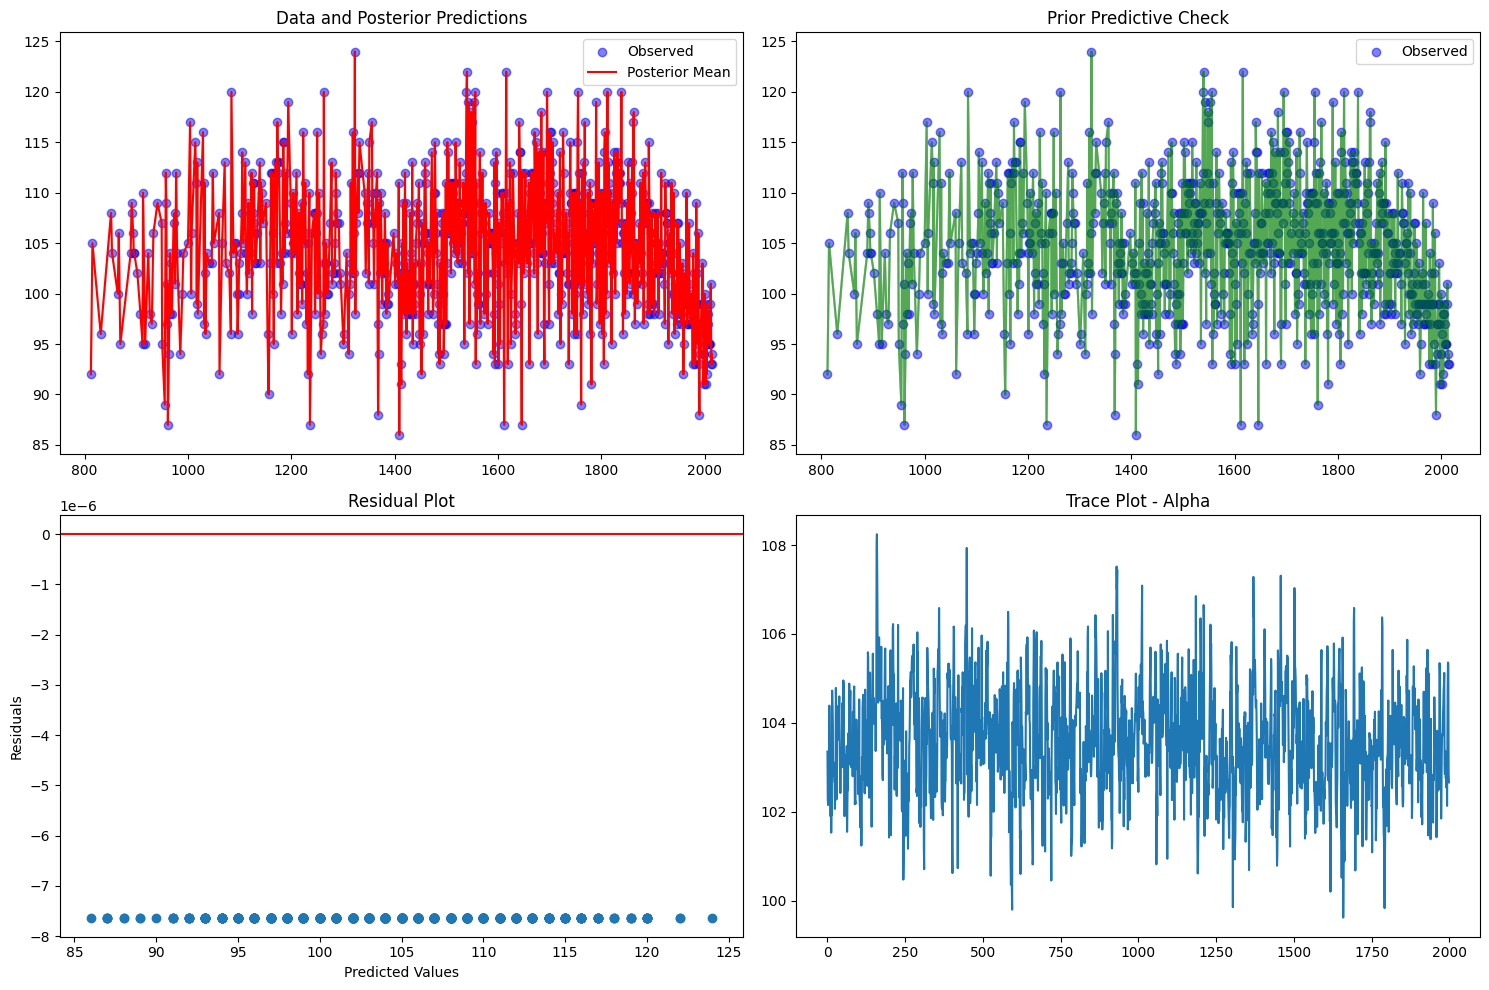

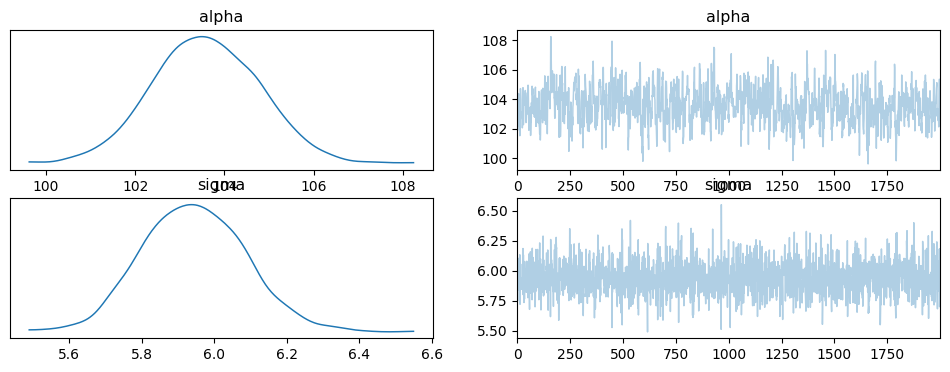

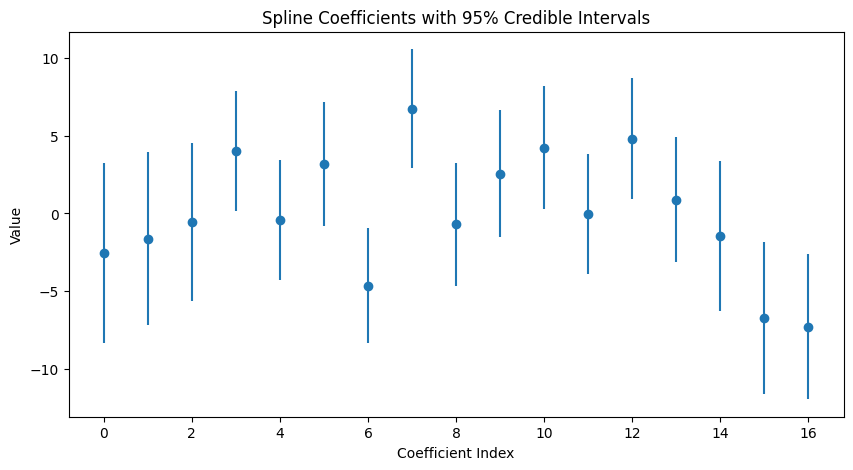

In [35]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
from jax import random
from numpyro.infer import MCMC, NUTS, Predictive
import arviz as az
import numpy as np


def blossom_spline():
    # Prior for intercept
    alpha = numpyro.sample("alpha", dist.Normal(100, 10))

    # Priors for coefficients
    betas = numpyro.sample("betas", dist.Normal(0, 5), sample_shape=(B.shape[1],))

    # Compute mean
    mu = alpha + jnp.dot(B, betas)

    # Prior for scale
    sigma = numpyro.sample("sigma", dist.Exponential(1))

    # Likelihood
    with numpyro.plate("obs", len(doy)):
        numpyro.sample("doy", dist.Normal(mu, sigma), obs=doy)


# Run inference
nuts_kernel = NUTS(blossom_spline)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key)

# Get samples
samples = mcmc.get_samples()

# Prior predictive
prior_key = random.PRNGKey(1)
prior_predictive = Predictive(blossom_spline, num_samples=1000)(prior_key)

# Posterior predictive
posterior_predictive = Predictive(blossom_spline, samples)(random.PRNGKey(2))

# Visualizations
plt.figure(figsize=(15, 10))

# 1. Data and posterior predictions
plt.subplot(221)
years = blossom_data["year"].values
# Plot data points
plt.scatter(years, doy, alpha=0.5, color="blue", label="Observed")

# Plot posterior predictions
post_pred_mean = jnp.mean(posterior_predictive["doy"], axis=0)
post_pred_std = jnp.std(posterior_predictive["doy"], axis=0)
plt.plot(years, post_pred_mean, color="red", label="Posterior Mean")
plt.fill_between(
    years,
    post_pred_mean - 2 * post_pred_std,
    post_pred_mean + 2 * post_pred_std,
    alpha=0.2,
    color="red",
)
plt.title("Data and Posterior Predictions")
plt.legend()

# 2. Prior predictive check
plt.subplot(222)
plt.scatter(years, doy, alpha=0.5, color="blue", label="Observed")
for i in range(0, 1000, 100):  # Plot every 100th sample
    plt.plot(years, prior_predictive["doy"][i], alpha=0.1, color="green")
plt.title("Prior Predictive Check")
plt.legend()

# 3. Residual plot
plt.subplot(223)
residuals = doy - post_pred_mean
plt.scatter(post_pred_mean, residuals)
plt.axhline(y=0, color="r", linestyle="-")
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")

# 4. Trace plots for some parameters
plt.subplot(224)
plt.plot(samples["alpha"])
plt.title("Trace Plot - Alpha")

plt.tight_layout()
plt.show()

# Additional diagnostic plots using arviz
data = az.from_numpyro(mcmc)
az.plot_trace(data, var_names=["alpha", "sigma"])
plt.show()

# Print summary statistics
# print("Posterior Summary:")
# mcmc.print_summary(var_names=['alpha', 'sigma'])

# Compute and plot the 95% credible intervals for the spline coefficients
betas_mean = samples["betas"].mean(axis=0)
betas_std = samples["betas"].std(axis=0)
plt.figure(figsize=(10, 5))
plt.errorbar(range(len(betas_mean)), betas_mean, yerr=2 * betas_std, fmt="o")
plt.title("Spline Coefficients with 95% Credible Intervals")
plt.xlabel("Coefficient Index")
plt.ylabel("Value")
plt.show()

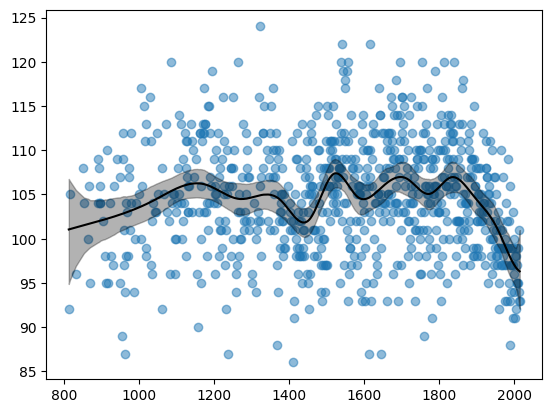

In [38]:
samples = mcmc.get_samples()

# Plot for model with alpha + betas
alpha_samples = samples["alpha"]
beta_samples = samples["betas"]  # shape: (n_samples, n_features)


# Calculate mus
def calculate_mus(alpha_samples, beta_samples, B):
    mus = []
    for i in range(len(B)):
        model_inp = B[i, :]
        # For each data point, calculate distribution of means
        mu_dist = alpha_samples.copy()
        for j in range(beta_samples.shape[1]):
            mu_dist += beta_samples[:, j] * model_inp[j]
        mus.append(mu_dist)
    return np.array(mus)


plt.scatter(blossom_data["year"], blossom_data["doy"], alpha=0.5, label="Data")

# Calculate and plot means and intervals for model with alpha
mus = calculate_mus(alpha_samples, beta_samples, B)
plt.plot(blossom_data["year"], mus.mean(axis=1), c="black", label="model with alpha")

# Calculate prediction intervals
pred_interval = 0.97
x = (1 - pred_interval) / 2
plt.fill_between(
    blossom_data["year"],
    np.quantile(mus, x, axis=1),
    np.quantile(mus, pred_interval + x, axis=1),
    alpha=0.3,
    color="black",
)